In [9]:
#!pip install tensorflow
#!pip install scikit-learn
#!pip install matplotlib
#!pip install pandas
#!pip install pyyaml
#!pip install shap
# !pip install keras_sequential_ascii
!pip install nnv


In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import yaml
import warnings
warnings.simplefilter("ignore")
#from joblib import load, dump
import argparse
#import shap
import numpy as np
import matplotlib.pyplot as plt
import functools
print = functools.partial(print, flush=True)
from sklearn.preprocessing import label_binarize, MinMaxScaler
from tensorflow import keras
from sklearn.metrics import (
    roc_curve,precision_score,
    precision_recall_curve,roc_auc_score,
     f1_score,accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    confusion_matrix,
    average_precision_score,
    recall_score
)

from sklearn.utils import class_weight
import shap
from keras_sequential_ascii import keras2ascii
from nnv import NNV


2023-11-27 13:01:19.300674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
warnings.simplefilter("ignore", category=DeprecationWarning)


In [7]:
with open(
        "../../configs/col_config.yaml"
    ) as fh:
        config_dict = yaml.safe_load(fh)

with open(
        "../../configs/var_class.yaml"
    ) as fh1:
        var_dict = yaml.safe_load(fh1)


In [17]:
set(var_dict.values())


{'3_prime_UTR_variant',
 '5_prime_UTR_variant',
 'NMD',
 'canonical intronic splice',
 'canonical splice',
 'complex_substitution',
 'frameshift_elongation',
 'frameshift_truncation',
 'inframe_deletion',
 'inframe_insertion',
 'intergenic',
 'intron_variant',
 'missense_variant',
 'other RNA',
 'polymorphic_pseudogene',
 'start_lost',
 'start_retained_variant',
 'stop_gained',
 'stop_lost',
 'stop_retained_variant',
 'synonymous'}

In [5]:
#amis = pd.read_csv("/Users/tarunmamidi/Downloads/AlphaMissense_hg38.tsv", low_memory=False, skiprows=3, sep='\t')
#amis.head()


In [18]:
clf = keras.models.load_model('../../model/Neural_network/')
clf.load_weights("../../model/weights.h5")
clf.summary()


2023-11-28 09:52:36.755957: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 239)               57360     
                                                                 
 dense_l0 (Dense)            (None, 161)               38640     
                                                                 
 dropout (Dropout)           (None, 161)               0         
                                                                 
 dense_last (Dense)          (None, 1)                 162       
                                                                 
Total params: 96,162
Trainable params: 96,162
Non-trainable params: 0
_________________________________________________________________


In [5]:
#keras2ascii(clf)


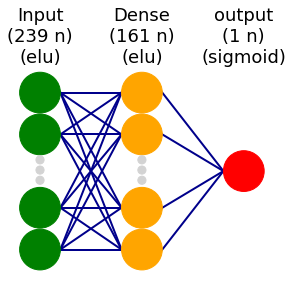

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [18]:
layersList = [
    {"title":"Input\n(239 n)\n(elu)", "units": 239, "color": "green", "edges_color":"darkBlue", "edges_width":2},
    {"title":"Dense\n(161 n)\n(elu)", "units": 161, "edges_color":"darkBlue", "edges_width":2,"color": "orange"},
    #{"title":"Dropout", "units": 161, "edges_color":"red", "edges_width":2},
    {"title":"output\n(1 n)\n(sigmoid)", "units": 1,"color": "red"},
]

NNV(layersList).render(save_to_file="DITTO.png")


In [19]:
X_train = pd.read_csv(f"../../data/external/train_class_data_80.csv.gz")
conq_class = X_train['consequence'].unique().tolist()
X_train = X_train.drop(config_dict["train_cols"]+['class'], axis=1)
feature_names = X_train.columns.tolist()
#X_train = X_train.sample(frac=1).reset_index(drop=True)
X_train = X_train.values
background = shap.kmeans(X_train, 10)
explainer = shap.KernelExplainer(clf.predict, background)
print(explainer.expected_value)
del X_train


1/1 [==============================] - 0s 239ms/step
[0.94780902]


In [20]:
X_test = pd.read_csv("../../data/external/test_class_data_20.csv.gz")
Y_test = X_test['class']
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(Y_test),y=Y_test)
class_weights = {i:w for i,w in enumerate(class_weights)}
var = X_test[config_dict["train_cols"]]
#var['class'] = Y_test
X_test = X_test.drop(config_dict["train_cols"], axis=1)
X_test = X_test.drop("class", axis=1)




In [16]:
X_test.head()


aloft.tolerant  aloft.recessive  aloft.dominant  cadd.phred  \
0         0.03175           0.5456         0.38385       4.416   
1         0.03175           0.5456         0.38385       4.416   
2         0.03175           0.5456         0.38385       4.416   
3         0.03175           0.5456         0.38385       4.416   
4         0.03175           0.5456         0.38385       4.416   

   chasmplus.score  chasmplus.pval  civic.molecular_profile_score  \
0            0.073           0.277                            7.5   
1            0.073           0.277                            7.5   
2            0.073           0.277                            7.5   
3            0.073           0.277                            7.5   
4            0.073           0.277                            7.5   

   cosmic.variant_count  cosmic_gene.occurrences  cscape.score  ...  \
0                   1.0                    850.0      0.183598  ...   
1                   1.0                    850.0      0.183598  ...   
2                   1.0                    850.0      0.183598  ...   
3                   1.0                    850.0      0.183598  ...   
4                   1.0                    850.0      0.183598  ...   

   mutationtaster.prediction_Automatic Polymorphism  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   mutationtaster.prediction_Damaging  mutationtaster.prediction_Polymorphism  \
0                                   0                                       0   
1                                   0                                       0   
2                                   0                                       0   
3                                   0                                       0   
4                                   0                                       0   

   mutationtaster.model_complex_aae  mutationtaster.model_simple_aae  \
0                                 0                                0   
1                                 0                                0   
2                                 0                                0   
3                                 0                                0   
4                                 0                                0   

   mutationtaster.model_without_aae  prec.stat_lof-tolerant  \
0                                 0                       0   
1                                 0                       0   
2                                 0                       0   
3                                 0                       0   
4                                 0                       0   

   prec.stat_recessive  sift.confidence_High  sift.confidence_Low  
0                    0                     1                    0  
1                    0                     1                    0  
2                    0                     1                    0  
3                    0                     1                    0  
4                    0                     1                    0  

[5 rows x 239 columns]

In [21]:
X_test.fillna(X_test.mean(), inplace=True)
feature_names = X_test.columns.tolist()
Y_test = label_binarize(
    Y_test.values, classes=list(np.unique(Y_test))
        ).ravel()
X_test['class'] = Y_test


In [9]:
var.head()


transcript     gene                                consequence  \
0  ENST00000293748  SYNGAP1  NMD_transcript_variant,synonymous_variant   
1  ENST00000418600  SYNGAP1                         synonymous_variant   
2  ENST00000428982  SYNGAP1                         synonymous_variant   
3  ENST00000449372  SYNGAP1                         synonymous_variant   
4  ENST00000628646  SYNGAP1                         synonymous_variant   

  protein_hgvs  cdna_hgvs chrom       pos ref_base alt_base  \
0   p.Pro1051=  c.3153T>G  chr6  33443750        T        G   
1   p.Pro1066=  c.3198T>G  chr6  33443750        T        G   
2   p.Pro1007=  c.3021T>G  chr6  33443750        T        G   
3   p.Pro1052=  c.3156T>G  chr6  33443750        T        G   
4   p.Pro1066=  c.3198T>G  chr6  33443750        T        G   

                       clingen.disease clingen.classification  \
0  complex neurodevelopmental disorder             Definitive   
1  complex neurodevelopmental disorder             Definitive   
2  complex neurodevelopmental disorder             Definitive   
3  complex neurodevelopmental disorder             Definitive   
4  complex neurodevelopmental disorder             Definitive   

   ncbigene.entrez omim.omim_id uniprot.acc   dbsnp.rsid  
0           8831.0          NaN      Q96PV0  rs781201249  
1           8831.0          NaN      Q96PV0  rs781201249  
2           8831.0          NaN      Q96PV0  rs781201249  
3           8831.0          NaN      Q96PV0  rs781201249  
4           8831.0          NaN      Q96PV0  rs781201249

In [10]:
feature_names


['aloft.tolerant',
 'aloft.recessive',
 'aloft.dominant',
 'cadd.phred',
 'chasmplus.score',
 'chasmplus.pval',
 'civic.molecular_profile_score',
 'cosmic.variant_count',
 'cosmic_gene.occurrences',
 'cscape.score',
 'cancer_genome_interpreter.resistant',
 'cancer_genome_interpreter.responsive',
 'clinpred.score',
 'dann.score',
 'dann_coding.dann_coding_score',
 'dgi.score',
 'ess_gene.indispensability_score',
 'exac_gene.exac_pli',
 'exac_gene.exac_pnull',
 'exac_gene.exac_del_score',
 'exac_gene.exac_dup_score',
 'exac_gene.exac_cnv_score',
 'fathmm.fathmm_score',
 'fathmm_xf_coding.fathmm_xf_coding_score',
 'funseq2.score',
 'gerp.gerp_rs',
 'ghis.ghis',
 'gwas_catalog.pval',
 'genehancer.score',
 'linsight.value',
 'lrt.lrt_score',
 'lrt.lrt_omega',
 'loftool.loftool_score',
 'mavedb.score',
 'metalr.score',
 'metasvm.score',
 'mutpred1.mutpred_general_score',
 'mutpred_indel.score',
 'mutation_assessor.score',
 'mutationtaster.score',
 'ndex_chd.numhit',
 'ndex.numhit',
 'ndex_si

In [16]:
#var['so'] = var['consequence']
#pd.pivot_table(var, values='consequence', index='so', columns='class',
#                          aggfunc='count').sort_values(by=['low_impact','high_impact'], ascending=False)


In [22]:
y_score = clf.predict(X_test.drop("class", axis=1))


6506/6506 [==============================] - 9s 1ms/step


In [23]:
y_score = 1 - y_score
y_score


array([[0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       ...,
       [4.4107437e-06],
       [4.4107437e-06],
       [1.0000000e+00]], dtype=float32)

In [20]:
y_score.round()


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

In [15]:
len(y_score)


208167

In [16]:
X_test.shape


(208167, 240)

In [24]:
# get maximum value from 4 spliceai columns

X_test['spliceai'] = X_test[['spliceai.ds_ag','spliceai.ds_al','spliceai.ds_dg','spliceai.ds_dl']].max(axis=1)
X_test['spliceai'].head()


0    0.0004
1    0.0004
2    0.0004
3    0.0004
4    0.0004
Name: spliceai, dtype: float64

<AxesSubplot:ylabel='Frequency'>

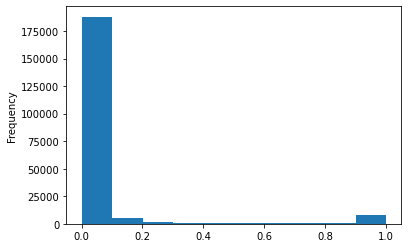

In [25]:
X_test['spliceai'].plot.hist()


In [23]:
X_test.tail()


aloft.tolerant  aloft.recessive  aloft.dominant  cadd.phred  \
208162         0.03175           0.5456         0.38385       8.510   
208163         0.03175           0.5456         0.38385       8.510   
208164         0.03175           0.5456         0.38385       8.393   
208165         0.03175           0.5456         0.38385       8.393   
208166         0.03175           0.5456         0.38385      26.400   

        chasmplus.score  chasmplus.pval  civic.molecular_profile_score  \
208162            0.073           0.277                            7.5   
208163            0.073           0.277                            7.5   
208164            0.073           0.277                            7.5   
208165            0.073           0.277                            7.5   
208166            0.073           0.277                            7.5   

        cosmic.variant_count  cosmic_gene.occurrences  cscape.score  ...  \
208162                   1.0                   3655.0      0.121814  ...   
208163                   1.0                   3655.0      0.121814  ...   
208164                   1.0                   5495.0      0.204376  ...   
208165                   1.0                   5495.0      0.204376  ...   
208166                   1.0                   2177.0      0.899148  ...   

        mutationtaster.prediction_Polymorphism  \
208162                                       0   
208163                                       0   
208164                                       0   
208165                                       0   
208166                                       0   

        mutationtaster.model_complex_aae  mutationtaster.model_simple_aae  \
208162                                 0                                0   
208163                                 0                                0   
208164                                 0                                0   
208165                                 0                                0   
208166                                 0                                1   

        mutationtaster.model_without_aae  prec.stat_lof-tolerant  \
208162                                 0                       0   
208163                                 0                       0   
208164                                 0                       0   
208165                                 0                       0   
208166                                 0                       0   

        prec.stat_recessive  sift.confidence_High  sift.confidence_Low  class  \
208162                    1                     0                    0      1   
208163                    1                     0                    0      1   
208164                    0                     1                    0      1   
208165                    0                     1                    0      1   
208166                    0                     1                    0      0   

        spliceai  
208162    0.0004  
208163    0.0004  
208164    0.0004  
208165    0.0004  
208166    0.0004  

[5 rows x 241 columns]

In [18]:
var.shape


(208167, 15)

In [26]:
var["DITTO"] = y_score
var.head()


transcript     gene                                consequence  \
0  ENST00000293748  SYNGAP1  NMD_transcript_variant,synonymous_variant   
1  ENST00000418600  SYNGAP1                         synonymous_variant   
2  ENST00000428982  SYNGAP1                         synonymous_variant   
3  ENST00000449372  SYNGAP1                         synonymous_variant   
4  ENST00000628646  SYNGAP1                         synonymous_variant   

  protein_hgvs  cdna_hgvs chrom       pos ref_base alt_base  \
0   p.Pro1051=  c.3153T>G  chr6  33443750        T        G   
1   p.Pro1066=  c.3198T>G  chr6  33443750        T        G   
2   p.Pro1007=  c.3021T>G  chr6  33443750        T        G   
3   p.Pro1052=  c.3156T>G  chr6  33443750        T        G   
4   p.Pro1066=  c.3198T>G  chr6  33443750        T        G   

                       clingen.disease clingen.classification  \
0  complex neurodevelopmental disorder             Definitive   
1  complex neurodevelopmental disorder             Definitive   
2  complex neurodevelopmental disorder             Definitive   
3  complex neurodevelopmental disorder             Definitive   
4  complex neurodevelopmental disorder             Definitive   

   ncbigene.entrez omim.omim_id uniprot.acc   dbsnp.rsid  DITTO  
0           8831.0          NaN      Q96PV0  rs781201249    0.0  
1           8831.0          NaN      Q96PV0  rs781201249    0.0  
2           8831.0          NaN      Q96PV0  rs781201249    0.0  
3           8831.0          NaN      Q96PV0  rs781201249    0.0  
4           8831.0          NaN      Q96PV0  rs781201249    0.0

In [27]:
var = pd.concat([var.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)
var.shape


(208167, 257)

<AxesSubplot:ylabel='Frequency'>

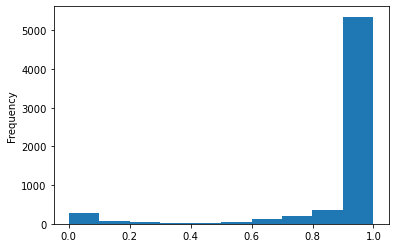

In [19]:
var[var['consequence'].str.contains('splice')]['spliceai'].plot.hist()


In [28]:
bench = var[['DITTO','cadd.phred','clinpred.score','metasvm.score', 'gerp.gerp_rs','spliceai','revel.score','sift.score','dann.score']]
bench.columns = ['DITTO','CADD','ClinPred','MetaSVM','GERP','spliceai','Revel','SIFT','DANN']


In [29]:
default_colors = {
        "DANN": "#de77ae",
        "SIFT": "#fee090",
        "Revel": "#542788",
        "VEST": "#5ab4ac",
        "GERP": "#d8b365",
        "MetaSVM": "#3182bd",
        "ClinPred": "#969696",
        "CADD": "#D55E00",
        "DITTO": "#b2182b",
        "spliceai": "#5ab4ac",
    }


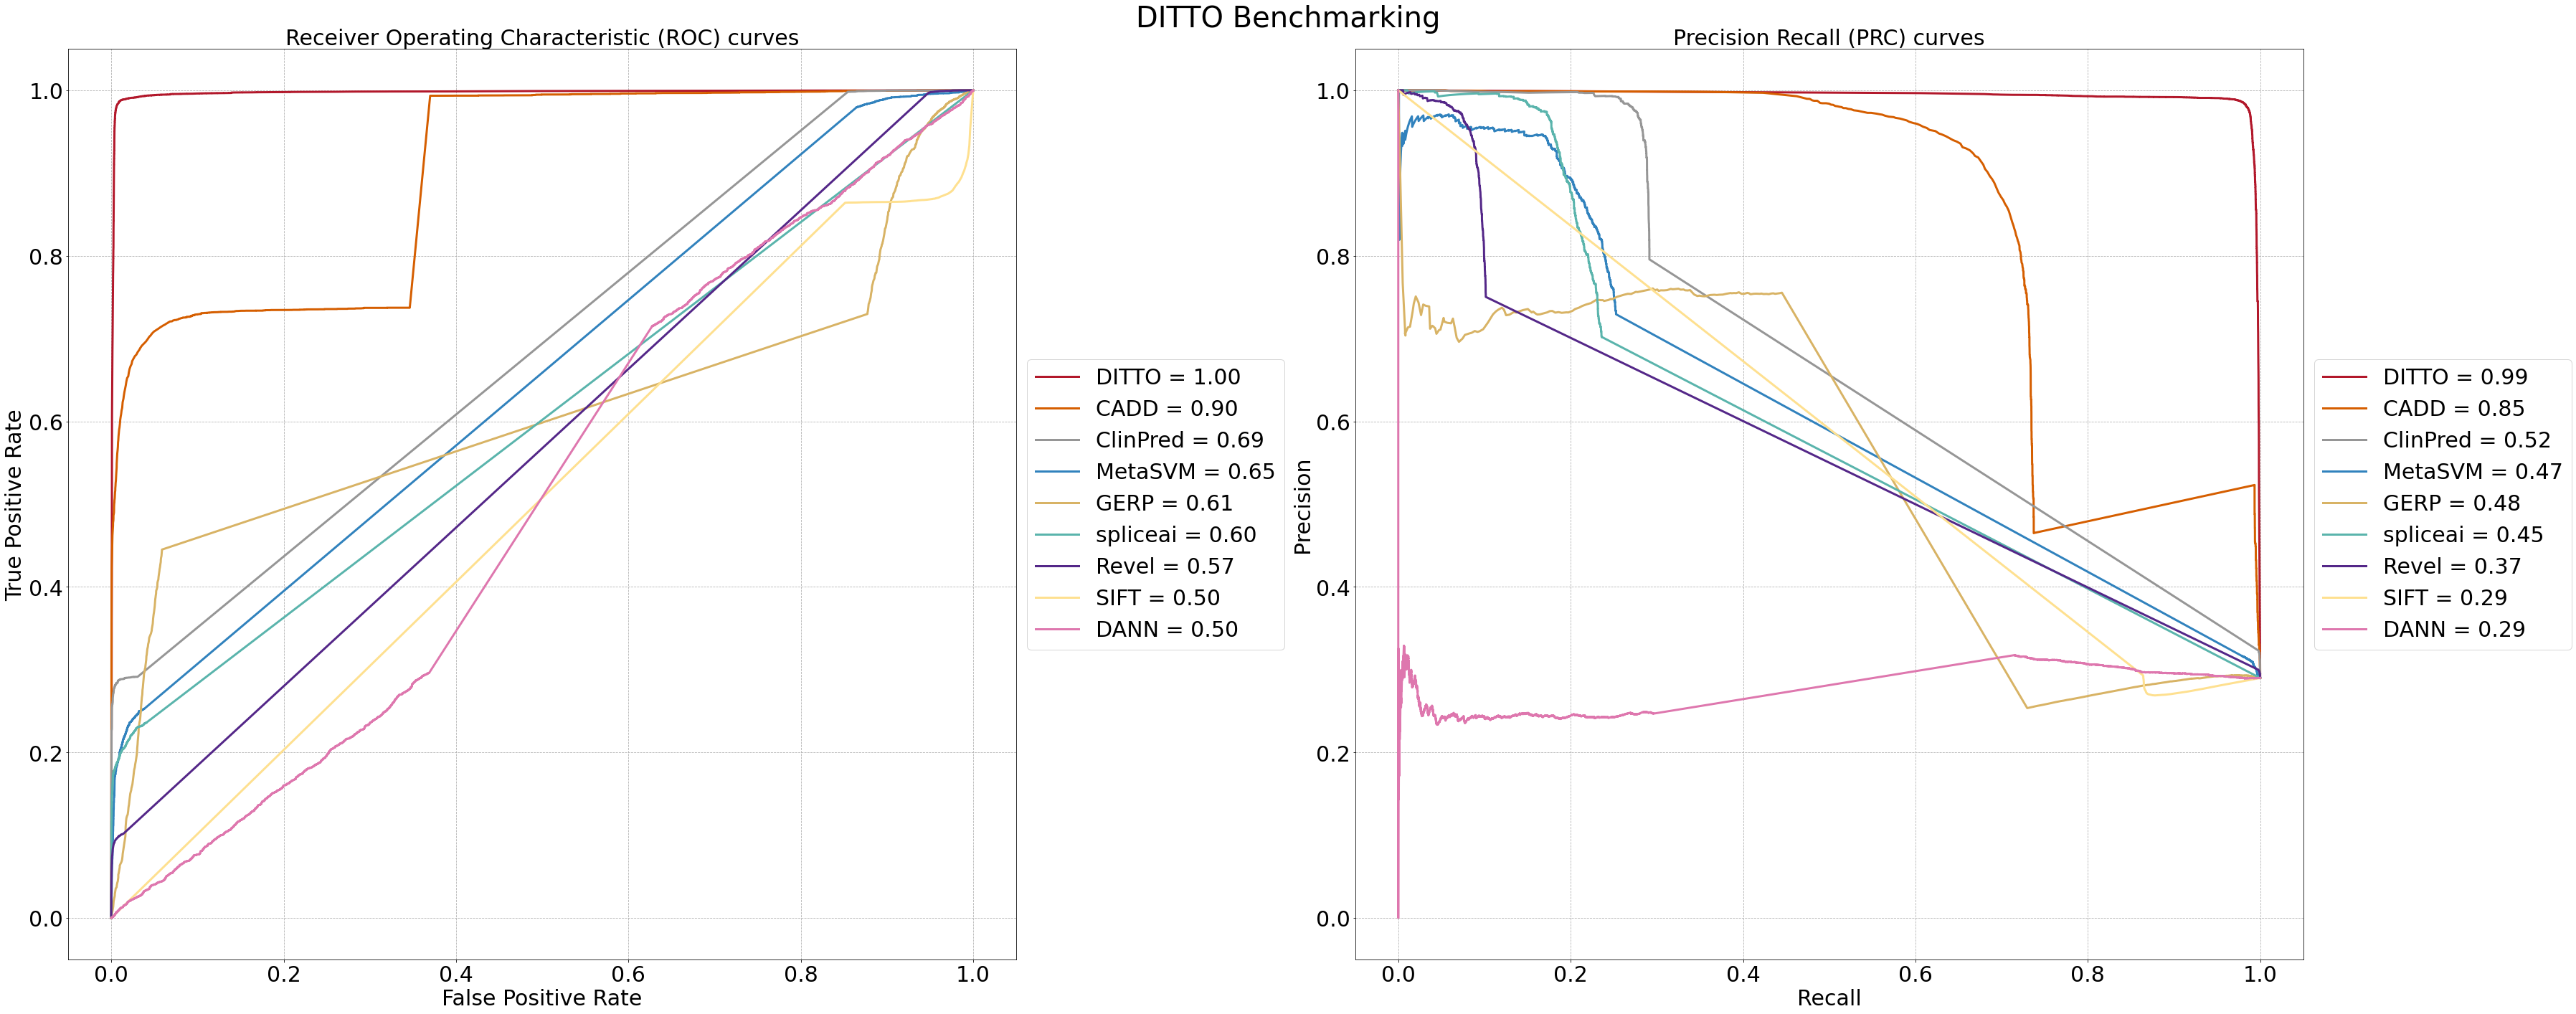

In [22]:
#bench = var[['cadd.phred','clinpred.score', 'chasmplus.score','dann.score','revel.score','metalr.score','metasvm.score','mutation_assessor.score','mutationtaster.score','sift.score','provean.score','vest.score','gerp.gerp_rs','DITTO']]
#bench.columns = ['CADD','ClinPred','chasmplus','DANN','Revel','MetaLR','MetaSVM','mutation_assessor','mutationtaster','SIFT','provean','VEST','GERP','DITTO']
Y_test = 1-var['class']

fig, [ax_roc, ax_prc] = plt.subplots(1, 2, figsize=(50, 20))

fig.suptitle(f"DITTO Benchmarking", fontsize=40)
fsize = 30
ax_roc.tick_params(axis='both', which='major', labelsize=fsize)
ax_prc.tick_params(axis='both', which='major', labelsize=fsize)
ax_roc.set_xlabel("False Positive Rate", fontsize=fsize)
ax_roc.set_ylabel("True Positive Rate", fontsize=fsize)
ax_roc.set_title("Receiver Operating Characteristic (ROC) curves", fontsize=fsize)
ax_roc.grid(linestyle="--")
ax_prc.set_xlabel("Recall", fontsize=fsize)
ax_prc.set_ylabel("Precision", fontsize=fsize)
ax_prc.set_title("Precision Recall (PRC) curves", fontsize=fsize)
ax_prc.grid(linestyle="--")

scores = {}
scores['roc'] = {}
scores['prc'] = {}
scores['f1'] = {}
for name in list(bench.columns):
        x = bench[name].values
        if name in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']:
            y_true = (x-np.min(x))/(np.max(x)-np.min(x))
        else:
            y_true = x
        fpr, tpr, _ = roc_curve(Y_test, y_true)
        auc = roc_auc_score(Y_test, y_true, average='weighted')
        auc = "{:.2f}".format(auc)
        scores['roc'][name] = auc
        ax_roc.plot(fpr,tpr,label=str(name)+" = "+str(auc), linewidth=3, c= default_colors[name])
        precision, recall, _ = precision_recall_curve(Y_test, y_true)
        prc = average_precision_score(Y_test, y_true, average='weighted')
        prc = "{:.2f}".format(prc)
        scores['prc'][name] = prc
        #f1 = f1_score(Y_test, y_true, sample_weight= weights, average='weighted')
        #scores['f1'][name] = "{:.2f}".format(np.nanmean(f1))
        ax_prc.plot(recall,precision,label=str(name)+" = "+str(prc), linewidth=3, c= default_colors[name])

ax_prc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
ax_roc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
fig.tight_layout()
#plt.savefig(
#            f"/data/project/worthey_lab/projects/experimental_pipelines/tarun/DITTO/data/processed/train_data_3_star/benchmarking/DITTO_ROC_PRC_benchmarking.pdf",
#            format="pdf",
#            dpi=1000,
#            bbox_inches="tight",
#        )




In [21]:
var.tail()


transcript    gene         consequence  protein_hgvs  \
208162  ENST00000413539    DYSF      intron_variant           NaN   
208163  ENST00000429174    DYSF      intron_variant           NaN   
208164  ENST00000288135     KIT  synonymous_variant     p.Thr666=   
208165  ENST00000412167     KIT  synonymous_variant     p.Thr662=   
208166  ENST00000328333  COL7A1    missense_variant  p.Gly2037Glu   

           cdna_hgvs chrom       pos ref_base alt_base clingen.disease  ...  \
208162  c.457+150A>G  chr2  71512071        A        G             NaN  ...   
208163  c.457+150A>G  chr2  71512071        A        G             NaN  ...   
208164     c.1998C>T  chr4  54729342        C        T             NaN  ...   
208165     c.1986C>T  chr4  54729342        C        T             NaN  ...   
208166     c.6110G>A  chr3  48575409        C        T             NaN  ...   

       mutationtaster.prediction_Damaging  \
208162                                  0   
208163                                  0   
208164                                  0   
208165                                  0   
208166                                  0   

        mutationtaster.prediction_Polymorphism  \
208162                                       0   
208163                                       0   
208164                                       0   
208165                                       0   
208166                                       0   

       mutationtaster.model_complex_aae mutationtaster.model_simple_aae  \
208162                                0                               0   
208163                                0                               0   
208164                                0                               0   
208165                                0                               0   
208166                                0                               1   

       mutationtaster.model_without_aae  prec.stat_lof-tolerant  \
208162                                0                       0   
208163                                0                       0   
208164                                0                       0   
208165                                0                       0   
208166                                0                       0   

        prec.stat_recessive  sift.confidence_High  sift.confidence_Low  class  
208162                    1                     0                    0      1  
208163                    1                     0                    0      1  
208164                    0                     1                    0      1  
208165                    0                     1                    0      1  
208166                    0                     1                    0      0  

[5 rows x 256 columns]

In [31]:
var1 = var.sort_values(by="DITTO", ascending=False).drop_duplicates(subset=['chrom', 'pos', 'ref_base', 'alt_base'], keep='first').reset_index(drop=True)
var1.tail()


transcript     gene          consequence protein_hgvs  \
37022  ENST00000591909    TUBB6  3_prime_UTR_variant          NaN   
37023  ENST00000289672   PKD1L1       intron_variant          NaN   
37024  ENST00000437951    PTCH1   synonymous_variant   p.Ser1169=   
37025  ENST00000644285  ANKRD11       intron_variant          NaN   
37026  ENST00000436005     PNKD       intron_variant          NaN   

           cdna_hgvs  chrom        pos ref_base alt_base  \
37022      c.*354C>G  chr18   12329537        C        G   
37023   c.4961-38C>T   chr7   47847109        G        A   
37024      c.3507C>T   chr9   95449168        G        A   
37025  c.745-6013G>A  chr16   89281204        C        T   
37026    c.173-24C>T   chr2  218340005        C        T   

                            clingen.disease  ...  \
37022                                   NaN  ...   
37023                                   NaN  ...   
37024  nevoid basal cell carcinoma syndrome  ...   
37025                                   NaN  ...   
37026                                   NaN  ...   

      mutationtaster.prediction_Polymorphism  \
37022                                      0   
37023                                      0   
37024                                      0   
37025                                      0   
37026                                      0   

       mutationtaster.model_complex_aae mutationtaster.model_simple_aae  \
37022                                 0                               0   
37023                                 0                               0   
37024                                 0                               0   
37025                                 0                               0   
37026                                 0                               0   

      mutationtaster.model_without_aae prec.stat_lof-tolerant  \
37022                                0                      0   
37023                                0                      0   
37024                                0                      0   
37025                                0                      0   
37026                                0                      0   

       prec.stat_recessive  sift.confidence_High  sift.confidence_Low  class  \
37022                    0                     0                    0      1   
37023                    0                     0                    0      1   
37024                    0                     1                    0      1   
37025                    0                     0                    0      1   
37026                    0                     0                    0      1   

       spliceai  
37022    0.0004  
37023    0.0004  
37024    0.0004  
37025    0.0004  
37026    0.0004  

[5 rows x 257 columns]

In [31]:
var1.chrom.value_counts()


chr2     3648
chr17    3168
chr1     2792
chr11    2221
chr16    2155
chr5     1953
chr3     1857
chr19    1839
chr12    1777
chr9     1730
chr7     1677
chr13    1611
chrX     1546
chr6     1244
chr10    1227
chr15    1198
chr14    1088
chr4     1027
chr8     1007
chr22     706
chr20     616
chr18     555
chr21     385
Name: chrom, dtype: int64

In [21]:
var1['consequence'].value_counts()


synonymous_variant                                                                  8683
intron_variant                                                                      6928
missense_variant                                                                    4066
processed_transcript                                                                2703
stop_gained                                                                         1944
frameshift_truncation                                                               1907
NMD_transcript_variant,3_prime_UTR_variant                                          1405
intron_variant,splice_site_variant                                                   919
frameshift_elongation                                                                900
intron_variant,NMD_transcript_variant                                                647
2kb_downstream_variant                                                               624
2kb_upstream_variant 

In [27]:
#var1 = var1.merge(amis, left_on=['chrom','pos','ref_base','alt_base'], right_on=['#CHROM','POS','REF','ALT'], how='left')
#var1.shape


In [45]:
Y_test = 1-var1['class']
Y_test.head()


0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

In [46]:
y_score = var1['DITTO']
Y_test.head()


0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

Precision: 0.9897399187091046
Recall: 0.9896561968293408
ROC_AUC: 0.9971389293121536
PRC_AUC: 0.9917333144301461
Accuracy: 0.9896561968293408
Confusion matrix:
[[26683   264]
 [  119  9961]]


Text(0.5, 1.0, 'Confusion matrix for test variants')

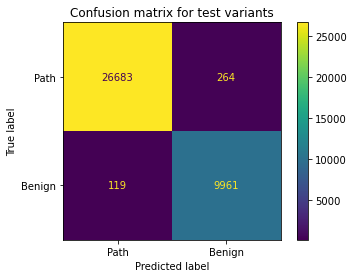

In [26]:
prc = precision_score(Y_test, y_score.round(), average="weighted")
recall = recall_score(Y_test, y_score.round(), average="weighted")
roc_auc = roc_auc_score(Y_test, y_score)
prc_auc = average_precision_score(Y_test, y_score, average="weighted")
# roc_auc = roc_auc_score(Y_test, np.argmax(y_score, axis=1))
accuracy = accuracy_score(Y_test, y_score.round())
# score = clf.score(X_train, Y_train)
matrix = confusion_matrix(Y_test, y_score.round())
cm = confusion_matrix(Y_test, y_score.round())
print(f"Precision: {prc}\nRecall: {recall}\nROC_AUC: {roc_auc}\nPRC_AUC: {prc_auc}\nAccuracy: {accuracy}\nConfusion matrix:\n{matrix}")
cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Path', 'Benign'])
cm.plot()
plt.title(f"Confusion matrix for test variants", fontsize=12)


In [32]:
bench = var1[['DITTO','cadd.phred','clinpred.score','metasvm.score', 'gerp.gerp_rs','spliceai','revel.score','dann.score','sift.score']]
bench.columns = ['DITTO','CADD','ClinPred','MetaSVM','GERP','spliceai','Revel','DANN','SIFT']



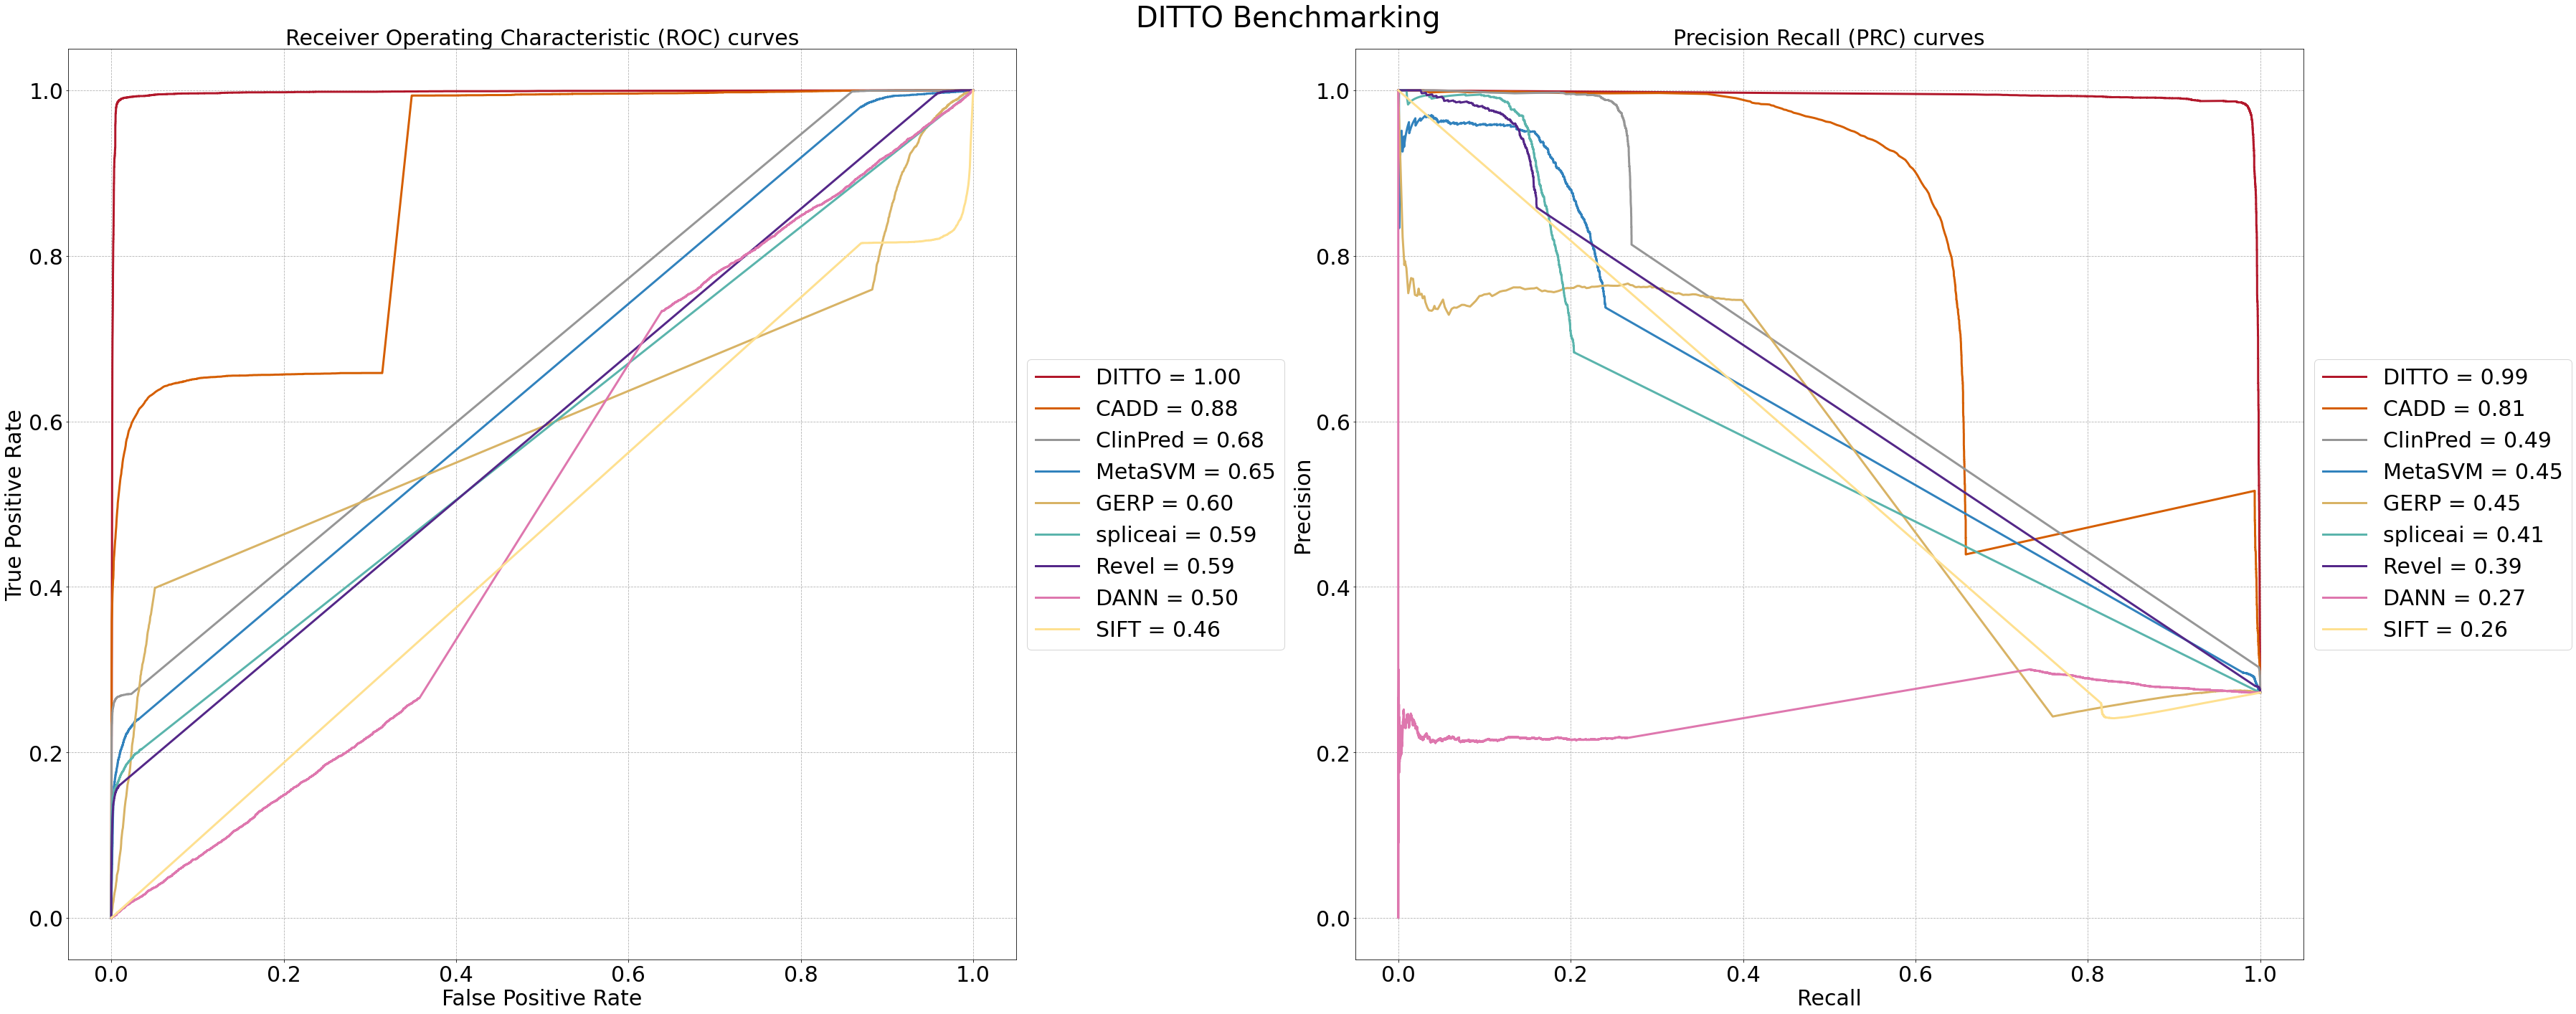

In [31]:

fig, [ax_roc, ax_prc] = plt.subplots(1, 2, figsize=(50, 20))

fig.suptitle(f"DITTO Benchmarking", fontsize=40)
fsize = 30
ax_roc.tick_params(axis='both', which='major', labelsize=fsize)
ax_prc.tick_params(axis='both', which='major', labelsize=fsize)
ax_roc.set_xlabel("False Positive Rate", fontsize=fsize)
ax_roc.set_ylabel("True Positive Rate", fontsize=fsize)
ax_roc.set_title("Receiver Operating Characteristic (ROC) curves", fontsize=fsize)
ax_roc.grid(linestyle="--")
ax_prc.set_xlabel("Recall", fontsize=fsize)
ax_prc.set_ylabel("Precision", fontsize=fsize)
ax_prc.set_title("Precision Recall (PRC) curves", fontsize=fsize)
ax_prc.grid(linestyle="--")

scores = {}
scores['roc'] = {}
scores['prc'] = {}
scores['f1'] = {}
for name in list(bench.columns):
        x = bench[name].values
        if name in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']:
            y_true = (x-np.min(x))/(np.max(x)-np.min(x))
        else:
            y_true = x
        fpr, tpr, _ = roc_curve(Y_test, y_true)
        auc = roc_auc_score(Y_test, y_true, average='weighted')
        auc = "{:.2f}".format(auc)
        scores['roc'][name] = auc
        ax_roc.plot(fpr,tpr,label=str(name)+" = "+str(auc), linewidth=3, c= default_colors[name])
        precision, recall, _ = precision_recall_curve(Y_test, y_true)
        prc = average_precision_score(Y_test, y_true, average='weighted')
        prc = "{:.2f}".format(prc)
        scores['prc'][name] = prc
        #f1 = f1_score(Y_test, y_true, sample_weight= weights, average='weighted')
        #scores['f1'][name] = "{:.2f}".format(np.nanmean(f1))
        ax_prc.plot(recall,precision,label=str(name)+" = "+str(prc), linewidth=3, c= default_colors[name])

ax_prc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
ax_roc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
fig.tight_layout()
#plt.savefig(
#            f"/data/project/worthey_lab/projects/experimental_pipelines/tarun/DITTO/data/processed/train_data_3_star/benchmarking/DITTO_ROC_PRC_benchmarking.pdf",
#            format="pdf",
#            dpi=1000,
#            bbox_inches="tight",
#        )


In [29]:
var.chrom.unique()


array(['chr6', 'chr13', 'chrX', 'chr14', 'chr11', 'chr18', 'chr12',
       'chr17', 'chr2', 'chr15', 'chr9', 'chr1', 'chr8', 'chr4', 'chr16',
       'chr21', 'chr5', 'chr19', 'chr3', 'chr10', 'chr7', 'chr20',
       'chr22'], dtype=object)

In [32]:
acc_scores_chr = {}
prc_scores_chr = {}
f1_scores_chr = {}
for name in var1.chrom.unique():
    acc_scores_chr[name] = {}
    prc_scores_chr[name] = {}
    f1_scores_chr[name] = {}
    for clf in bench.columns:
        index_list = var1[var1.chrom == name].index
        x = bench[bench.index.isin(index_list)][clf].values
        if clf in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']:
            x_norm = (x-np.min(x))/(np.max(x)-np.min(x))
        else:
            x_norm = x

        acc = accuracy_score(Y_test[index_list],  x_norm.round())
        acc = "{:.2f}".format(acc)
        acc_scores_chr[name][clf] = acc

        prc = precision_score(Y_test[index_list],  x_norm.round())
        prc = "{:.2f}".format(prc)
        prc_scores_chr[name][clf] = prc

        f1 = f1_score(Y_test[index_list],  x_norm.round())
        f1_scores_chr[name][clf] = "{:.2f}".format(f1)


In [33]:
f1_scores_chr


{'chr3': {'DITTO': '0.99',
  'CADD': '0.71',
  'ClinPred': '0.51',
  'MetaSVM': '0.40',
  'GERP': '0.45',
  'spliceai': '0.29',
  'Revel': '0.32',
  'DANN': '0.43',
  'SIFT': '0.39'},
 'chr19': {'DITTO': '0.98',
  'CADD': '0.51',
  'ClinPred': '0.59',
  'MetaSVM': '0.54',
  'GERP': '0.34',
  'spliceai': '0.22',
  'Revel': '0.35',
  'DANN': '0.35',
  'SIFT': '0.27'},
 'chr11': {'DITTO': '0.98',
  'CADD': '0.63',
  'ClinPred': '0.41',
  'MetaSVM': '0.37',
  'GERP': '0.49',
  'spliceai': '0.30',
  'Revel': '0.28',
  'DANN': '0.46',
  'SIFT': '0.43'},
 'chr1': {'DITTO': '0.98',
  'CADD': '0.71',
  'ClinPred': '0.50',
  'MetaSVM': '0.42',
  'GERP': '0.40',
  'spliceai': '0.23',
  'Revel': '0.36',
  'DANN': '0.40',
  'SIFT': '0.33'},
 'chr17': {'DITTO': '0.98',
  'CADD': '0.52',
  'ClinPred': '0.33',
  'MetaSVM': '0.27',
  'GERP': '0.59',
  'spliceai': '0.28',
  'Revel': '0.19',
  'DANN': '0.58',
  'SIFT': '0.53'},
 'chr8': {'DITTO': '0.98',
  'CADD': '0.74',
  'ClinPred': '0.28',
  'MetaSVM

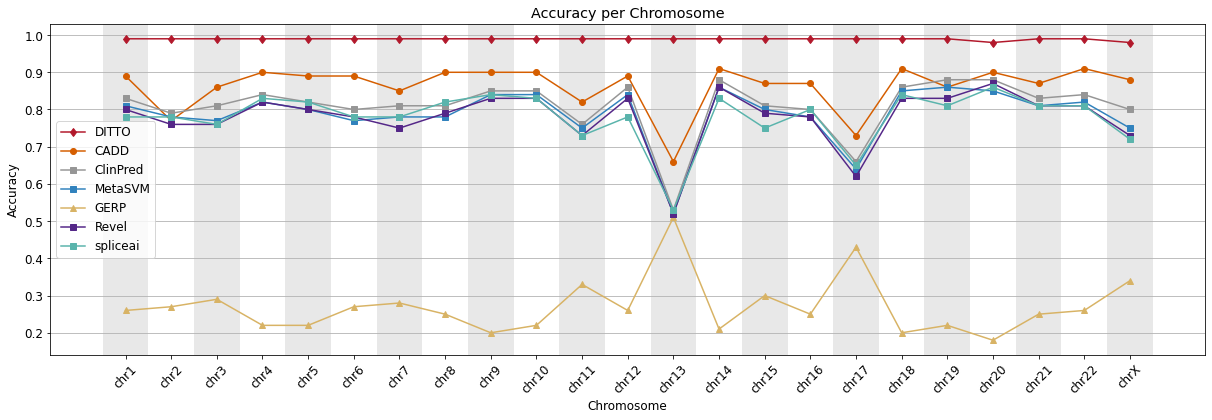

In [34]:
# Extract the chromosome names and values in the specified order
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19',
 'chr20', 'chr21', 'chr22', 'chrX']
CADD_values = [float(acc_scores_chr[chr]['CADD']) for chr in chromosomes]
ClinPred_values = [float(acc_scores_chr[chr]['ClinPred']) for chr in chromosomes]
Revel_values = [float(acc_scores_chr[chr]['Revel']) for chr in chromosomes]
MetaSVM_values = [float(acc_scores_chr[chr]['MetaSVM']) for chr in chromosomes]
GERP_values = [float(acc_scores_chr[chr]['GERP']) for chr in chromosomes]
DITTO_values = [float(acc_scores_chr[chr]['DITTO']) for chr in chromosomes]
spliceai_values = [float(acc_scores_chr[chr]['spliceai']) for chr in chromosomes]

# Create a Manhattan-style bar plot
plt.figure(figsize=(17, 6))
plt.rcParams.update({'font.size': 12})
plt.plot(chromosomes, DITTO_values, marker='d', label='DITTO', linestyle='-', c= default_colors['DITTO'])
plt.plot(chromosomes, CADD_values, marker='o', label='CADD', linestyle='-', c= default_colors['CADD'])
plt.plot(chromosomes, ClinPred_values, marker='s', label='ClinPred', linestyle='-', c= default_colors['ClinPred'])
plt.plot(chromosomes, MetaSVM_values, marker='s', label='MetaSVM', linestyle='-', c= default_colors['MetaSVM'])
plt.plot(chromosomes, GERP_values, marker='^', label='GERP', linestyle='-', c= default_colors['GERP'])
plt.plot(chromosomes, Revel_values, marker='s', label='Revel', linestyle='-', c= default_colors['Revel'])
plt.plot(chromosomes, spliceai_values, marker='s', label='spliceai', linestyle='-', c= default_colors['spliceai'])

plt.xlabel('Chromosome')
plt.ylabel('Accuracy')
plt.title('Accuracy per Chromosome')
plt.legend()
plt.grid(axis='y')

# Add shaded rectangles instead of grid lines
ax = plt.gca()
for i in range(len(chromosomes)):
    if i % 2 == 0:  # Shade every other chromosome
        ax.axvspan(i - 0.5, i + 0.5, facecolor='lightgray', alpha=0.5)

plt.xticks(range(len(chromosomes)), chromosomes, rotation=45)  # Set x-axis labels

plt.tight_layout()
plt.show()


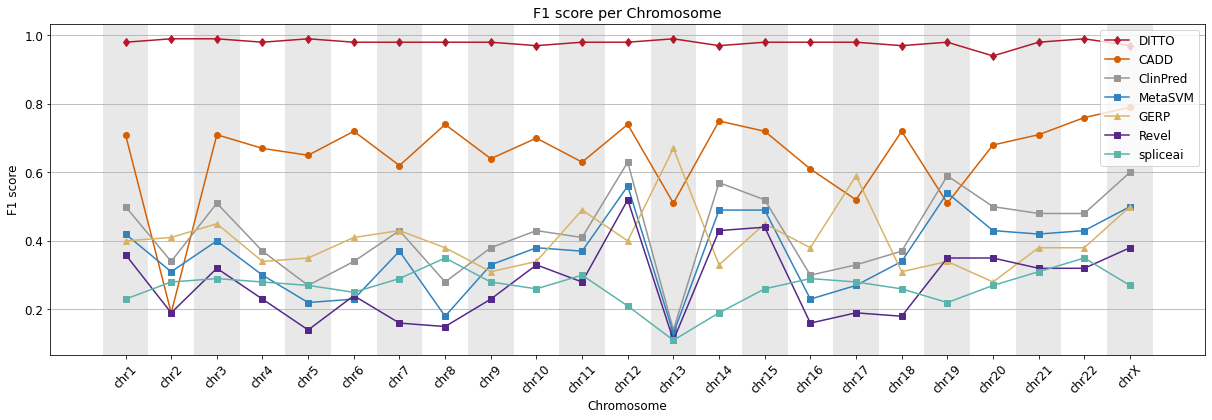

In [35]:
# Extract the chromosome names and values in the specified order
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19',
 'chr20', 'chr21', 'chr22', 'chrX']
CADD_values = [float(f1_scores_chr[chr]['CADD']) for chr in chromosomes]
ClinPred_values = [float(f1_scores_chr[chr]['ClinPred']) for chr in chromosomes]
Revel_values = [float(f1_scores_chr[chr]['Revel']) for chr in chromosomes]
MetaSVM_values = [float(f1_scores_chr[chr]['MetaSVM']) for chr in chromosomes]
GERP_values = [float(f1_scores_chr[chr]['GERP']) for chr in chromosomes]
DITTO_values = [float(f1_scores_chr[chr]['DITTO']) for chr in chromosomes]
spliceai_values = [float(f1_scores_chr[chr]['spliceai']) for chr in chromosomes]

# Create a Manhattan-style bar plot
plt.figure(figsize=(17, 6))
plt.rcParams.update({'font.size': 12})
plt.plot(chromosomes, DITTO_values, marker='d', label='DITTO', linestyle='-', c= default_colors['DITTO'])
plt.plot(chromosomes, CADD_values, marker='o', label='CADD', linestyle='-', c= default_colors['CADD'])
plt.plot(chromosomes, ClinPred_values, marker='s', label='ClinPred', linestyle='-', c= default_colors['ClinPred'])
plt.plot(chromosomes, MetaSVM_values, marker='s', label='MetaSVM', linestyle='-', c= default_colors['MetaSVM'])
plt.plot(chromosomes, GERP_values, marker='^', label='GERP', linestyle='-', c= default_colors['GERP'])
plt.plot(chromosomes, Revel_values, marker='s', label='Revel', linestyle='-', c= default_colors['Revel'])
plt.plot(chromosomes, spliceai_values, marker='s', label='spliceai', linestyle='-', c= default_colors['spliceai'])

plt.xlabel('Chromosome')
plt.ylabel('F1 score')
plt.title('F1 score per Chromosome')
plt.legend()
plt.grid(axis='y')

# Add shaded rectangles instead of grid lines
ax = plt.gca()
for i in range(len(chromosomes)):
    if i % 2 == 0:  # Shade every other chromosome
        ax.axvspan(i - 0.5, i + 0.5, facecolor='lightgray', alpha=0.5)

plt.xticks(range(len(chromosomes)), chromosomes, rotation=45)  # Set x-axis labels

plt.tight_layout()
plt.show()


In [34]:
# Assuming you have a DataFrame called df with a column called 'column1'
# and a dictionary called my_dict

var1['so'] = var1['consequence'].map(var_dict)
var1['so1'] = var1['so']


In [38]:
pd.pivot_table(var1,  index='so', columns='chrom', values='so1',
                          aggfunc='count').T#.sort_values(by=['low_impact','high_impact'], ascending=False)
#var1['chromo'] = var1['chrom']
#pd.pivot_table(var1,  index='chromo', columns='so', values='chrom',
#                          aggfunc='count')#.sort_values(by=['low_impact','high_impact'], ascending=False)


so     3_prime_UTR_variant  5_prime_UTR_variant    NMD  \
chrom                                                    
chr1                  48.0                 31.0  138.0   
chr10                 40.0                 17.0  118.0   
chr11                 33.0                 15.0  144.0   
chr12                 22.0                 23.0  132.0   
chr13                 13.0                  4.0   36.0   
chr14                 18.0                 26.0   58.0   
chr15                 18.0                  8.0  177.0   
chr16                 26.0                 14.0  251.0   
chr17                 40.0                 74.0  266.0   
chr18                  6.0                  6.0   42.0   
chr19                 40.0                 12.0  193.0   
chr2                  39.0                 94.0  261.0   
chr20                 22.0                  9.0   37.0   
chr21                 12.0                  5.0   29.0   
chr22                  9.0                 12.0   87.0   
chr3                  23.0                 19.0  241.0   
chr4                  33.0                 13.0   98.0   
chr5                  40.0                 19.0  530.0   
chr6                  36.0                  9.0   76.0   
chr7                  22.0                 24.0  114.0   
chr8                  20.0                 17.0  174.0   
chr9                  15.0                 22.0  152.0   
chrX                  27.0                 18.0   61.0   

so     canonical intronic splice  canonical splice  complex_substitution  \
chrom                                                                      
chr1                        62.0               2.0                   NaN   
chr10                       30.0               1.0                   NaN   
chr11                       70.0               2.0                   NaN   
chr12                       32.0               NaN                   NaN   
chr13                       31.0               1.0                   NaN   
chr14                       12.0               2.0                   NaN   
chr15                       26.0               2.0                   NaN   
chr16                       53.0               4.0                   NaN   
chr17                      131.0               2.0                   NaN   
chr18                        9.0               NaN                   NaN   
chr19                       34.0               1.0                   1.0   
chr2                        93.0               5.0                   1.0   
chr20                        9.0               NaN                   NaN   
chr21                       15.0               NaN                   NaN   
chr22                       21.0               2.0                   NaN   
chr3                        48.0               1.0                   NaN   
chr4                        15.0               2.0                   1.0   
chr5                        30.0               1.0                   NaN   
chr6                        40.0               1.0                   NaN   
chr7                        57.0               1.0                   NaN   
chr8                        25.0               1.0                   NaN   
chr9                        33.0               3.0                   NaN   
chrX                        43.0               1.0                   NaN   

so     frameshift_elongation  frameshift_truncation  inframe_deletion  \
chrom                                                                   
chr1                    36.0                  109.0               6.0   
chr10                   28.0                   35.0               3.0   
chr11                   75.0                  137.0               9.0   
chr12                   26.0                   68.0               7.0   
chr13                  164.0                  338.0               1.0   
chr14                   18.0                   33.0               3.0   
chr15                   25.0                   60.0             

<AxesSubplot:xlabel='so'>

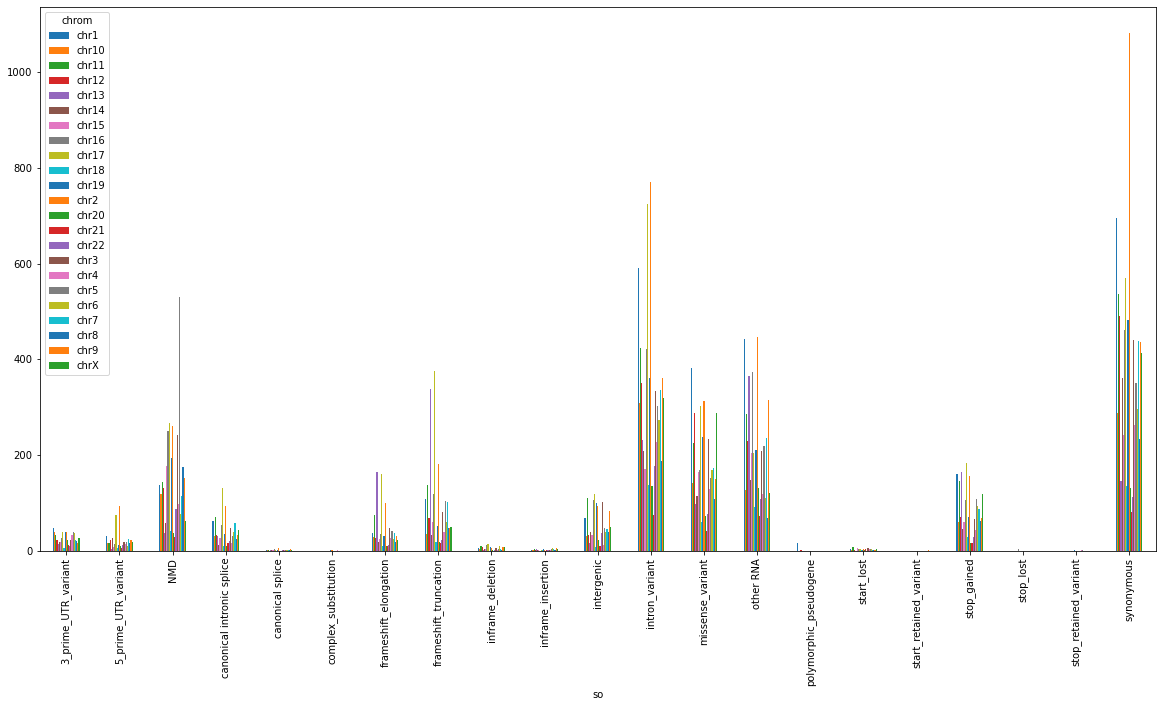

In [43]:
pd.pivot_table(var1,  index='so', columns='chrom', values='so1',
                          aggfunc='count').plot(kind='bar', figsize=(20,10), linewidth=3)


In [36]:
var1[var1['chrom']=='chr13']['clingen.disease'].value_counts()


breast-ovarian cancer, familial, susceptibility to, 2;Fanconi anemia complementation group D1    1137
Wilson disease                                                                                     70
autosomal recessive nonsyndromic deafness;syndromic genetic deafness                               26
xeroderma pigmentosum group G                                                                       9
auditory neuropathy                                                                                 8
Waardenburg syndrome type 4A;Waardenburg syndrome type 4A                                           4
nonsyndromic genetic deafness;Clouston syndrome                                                     4
Leigh syndrome                                                                                      2
factor VII deficiency                                                                               2
high myopia-sensorineural deafness syndrome                                       

Text(0.5, 1.0, 'Confusion matrix of DITTO for chr13 variants')

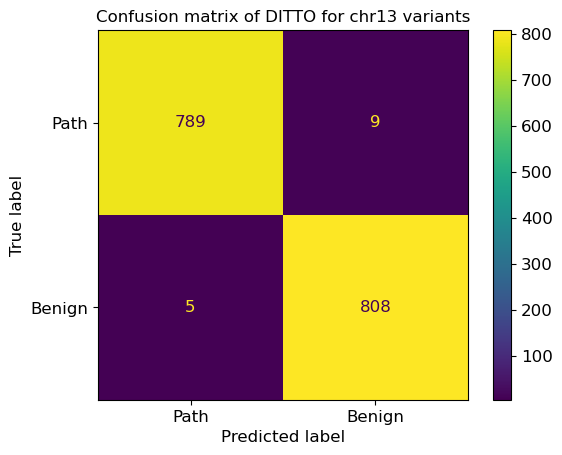

In [66]:
name = 'chr13'
clf = 'DITTO'
index_list = var1[var1.chrom == name].index
x = bench[bench.index.isin(index_list)][clf].values

cm = confusion_matrix(Y_test[index_list],x.round())
cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Path', 'Benign'])
cm.plot()
plt.title(f"Confusion matrix of DITTO for chr13 variants", fontsize=12)


In [77]:
var1.consequence.value_counts()


synonymous_variant                                                                  8683
intron_variant                                                                      6928
missense_variant                                                                    4066
processed_transcript                                                                2703
stop_gained                                                                         1944
frameshift_truncation                                                               1907
NMD_transcript_variant,3_prime_UTR_variant                                          1405
intron_variant,splice_site_variant                                                   919
frameshift_elongation                                                                900
intron_variant,NMD_transcript_variant                                                647
2kb_downstream_variant                                                               624
2kb_upstream_variant 

In [47]:
#conqs = {'missense_variant':'missense', 'synonymous_variant':'synonymous', 'stop_gained':'stop-gained', 'frameshift_truncation':'frameshift truncating',
#       'frameshift_elongation':'frameshift elongating', 'intron_variant':'intron','intron_variant,splice_site_variant':'intronic splice site','splice_site_variant':'exonic splice site'}

conqs = var_dict
roc_scores = {}
prc_scores = {}
f1_scores = {}

for consq in conqs.keys():
        roc_scores[conqs[consq]] = {}
        prc_scores[conqs[consq]] = {}
        f1_scores[conqs[consq]] = {}

        index_list = var1[var1.consequence == consq].index
        missense = bench[bench.index.isin(index_list)]

        missense_y = Y_test[Y_test.index.isin(index_list)].values

        for name in list(missense.columns):
                if name in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']:
                    x_norm = (missense-np.min(missense))/(np.max(missense)-np.min(missense))
                else:
                    x_norm = missense
                try:
                        auc = accuracy_score(missense_y, x_norm[name].fillna(0).values)
                except:
                        auc=0
                roc_scores[conqs[consq]][name] = round(auc,2)
                try:
                        prc = precision_score(missense_y, x_norm[name].fillna(0).values)
                except:
                        prc=0
                prc_scores[conqs[consq]][name] = round(prc,2)
                try:
                        f1 = f1_score(missense_y, x_norm[name].fillna(0).values.round())
                except:
                        f1=0
                f1_scores[conqs[consq]][name] = round(f1,2)

#pd.DataFrame(roc_scores).to_csv("/data/project/worthey_lab/projects/experimental_pipelines/tarun/DITTO4NF/data/processed/tuning/NN_roc_scores.csv")
#pd.DataFrame(prc_scores).to_csv("/data/project/worthey_lab/projects/experimental_pipelines/tarun/DITTO4NF/data/processed/tuning/NN_prc_scores.csv")
#pd.DataFrame(f1_scores).to_csv("/data/project/worthey_lab/projects/experimental_pipelines/tarun/DITTO4NF/data/processed/tuning/NN_f1_scores.csv")


In [48]:
f1_scores


{'NMD': {'DITTO': 0.0,
  'CADD': 0.0,
  'ClinPred': 0.0,
  'MetaSVM': 0.0,
  'GERP': 0.0,
  'spliceai': 0.0,
  'Revel': 0.0,
  'DANN': 0.0,
  'SIFT': 0.0},
 'synonymous': {'DITTO': 0.0,
  'CADD': 0.0,
  'ClinPred': 0.0,
  'MetaSVM': 0.0,
  'GERP': 0.0,
  'spliceai': 0.0,
  'Revel': 0.0,
  'DANN': 0.0,
  'SIFT': 0.0},
 'frameshift_elongation': {'DITTO': 1.0,
  'CADD': 0.0,
  'ClinPred': 0.0,
  'MetaSVM': 0.0,
  'GERP': 0.0,
  'spliceai': 0.0,
  'Revel': 0.0,
  'DANN': 1.0,
  'SIFT': 1.0},
 'other RNA': {'DITTO': 0.0,
  'CADD': 0.0,
  'ClinPred': 0.0,
  'MetaSVM': 0.0,
  'GERP': 0.0,
  'spliceai': 0.0,
  'Revel': 0.0,
  'DANN': 0.0,
  'SIFT': 0.0},
 'stop_gained': {'DITTO': 1.0,
  'CADD': 0.0,
  'ClinPred': 0.0,
  'MetaSVM': 0.0,
  'GERP': 0.0,
  'spliceai': 0.0,
  'Revel': 0.0,
  'DANN': 1.0,
  'SIFT': 1.0},
 'intron_variant': {'DITTO': 1.0,
  'CADD': 0.0,
  'ClinPred': 0.0,
  'MetaSVM': 0.0,
  'GERP': 0.0,
  'spliceai': 1.0,
  'Revel': 0.0,
  'DANN': 1.0,
  'SIFT': 1.0},
 'missense_var

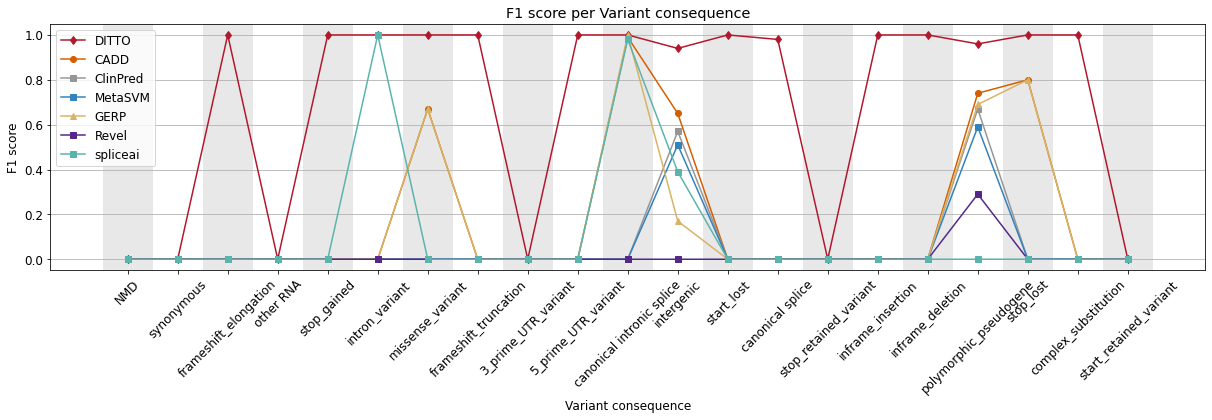

In [49]:
# Extract the chromosome names and values in the specified order
chromosomes = f1_scores.keys()
CADD_values = [float(f1_scores[chr]['CADD']) for chr in chromosomes]
ClinPred_values = [float(f1_scores[chr]['ClinPred']) for chr in chromosomes]
Revel_values = [float(f1_scores[chr]['Revel']) for chr in chromosomes]
MetaSVM_values = [float(f1_scores[chr]['MetaSVM']) for chr in chromosomes]
GERP_values = [float(f1_scores[chr]['GERP']) for chr in chromosomes]
DITTO_values = [float(f1_scores[chr]['DITTO']) for chr in chromosomes]
spliceai_values = [float(f1_scores[chr]['spliceai']) for chr in chromosomes]

# Create a Manhattan-style bar plot
plt.figure(figsize=(17, 6))
plt.rcParams.update({'font.size': 12})
plt.plot(chromosomes, DITTO_values, marker='d', label='DITTO', linestyle='-', c= default_colors['DITTO'])
plt.plot(chromosomes, CADD_values, marker='o', label='CADD', linestyle='-', c= default_colors['CADD'])
plt.plot(chromosomes, ClinPred_values, marker='s', label='ClinPred', linestyle='-', c= default_colors['ClinPred'])
plt.plot(chromosomes, MetaSVM_values, marker='s', label='MetaSVM', linestyle='-', c= default_colors['MetaSVM'])
plt.plot(chromosomes, GERP_values, marker='^', label='GERP', linestyle='-', c= default_colors['GERP'])
plt.plot(chromosomes, Revel_values, marker='s', label='Revel', linestyle='-', c= default_colors['Revel'])
plt.plot(chromosomes, spliceai_values, marker='s', label='spliceai', linestyle='-', c= default_colors['spliceai'])

plt.xlabel('Variant consequence')
plt.ylabel('F1 score')
plt.title('F1 score per Variant consequence')
plt.legend()
plt.grid(axis='y')

# Add shaded rectangles instead of grid lines
ax = plt.gca()
for i in range(len(chromosomes)):
    if i % 2 == 0:  # Shade every other chromosome
        ax.axvspan(i - 0.5, i + 0.5, facecolor='lightgray', alpha=0.5)

plt.xticks(range(len(chromosomes)), chromosomes, rotation=45)  # Set x-axis labels

plt.tight_layout()
plt.show()


In [42]:
print(var1[var1['consequence'].str.contains("missense_variant")].shape)
var1[var1['consequence'].str.contains("missense_variant")].chrom.value_counts()


(4376, 256)


chr1     405
chr2     329
chr17    320
chrX     298
chr12    296
chr3     252
chr19    249
chr11    249
chr16    188
chr15    186
chr7     185
chr6     176
chr5     173
chr9     169
chr10    144
chr4     143
chr14    123
chr8     119
chr13     99
chr22     85
chr20     75
chr18     64
chr21     49
Name: chrom, dtype: int64

In [47]:
bench = var1[['DITTO','clinpred.score','metasvm.score','vest.score','revel.score','cadd.phred','gerp.gerp_rs','dann.score','sift.score']]
bench.columns = ['DITTO','ClinPred','MetaSVM','VEST','Revel','CADD','GERP','DANN','SIFT']



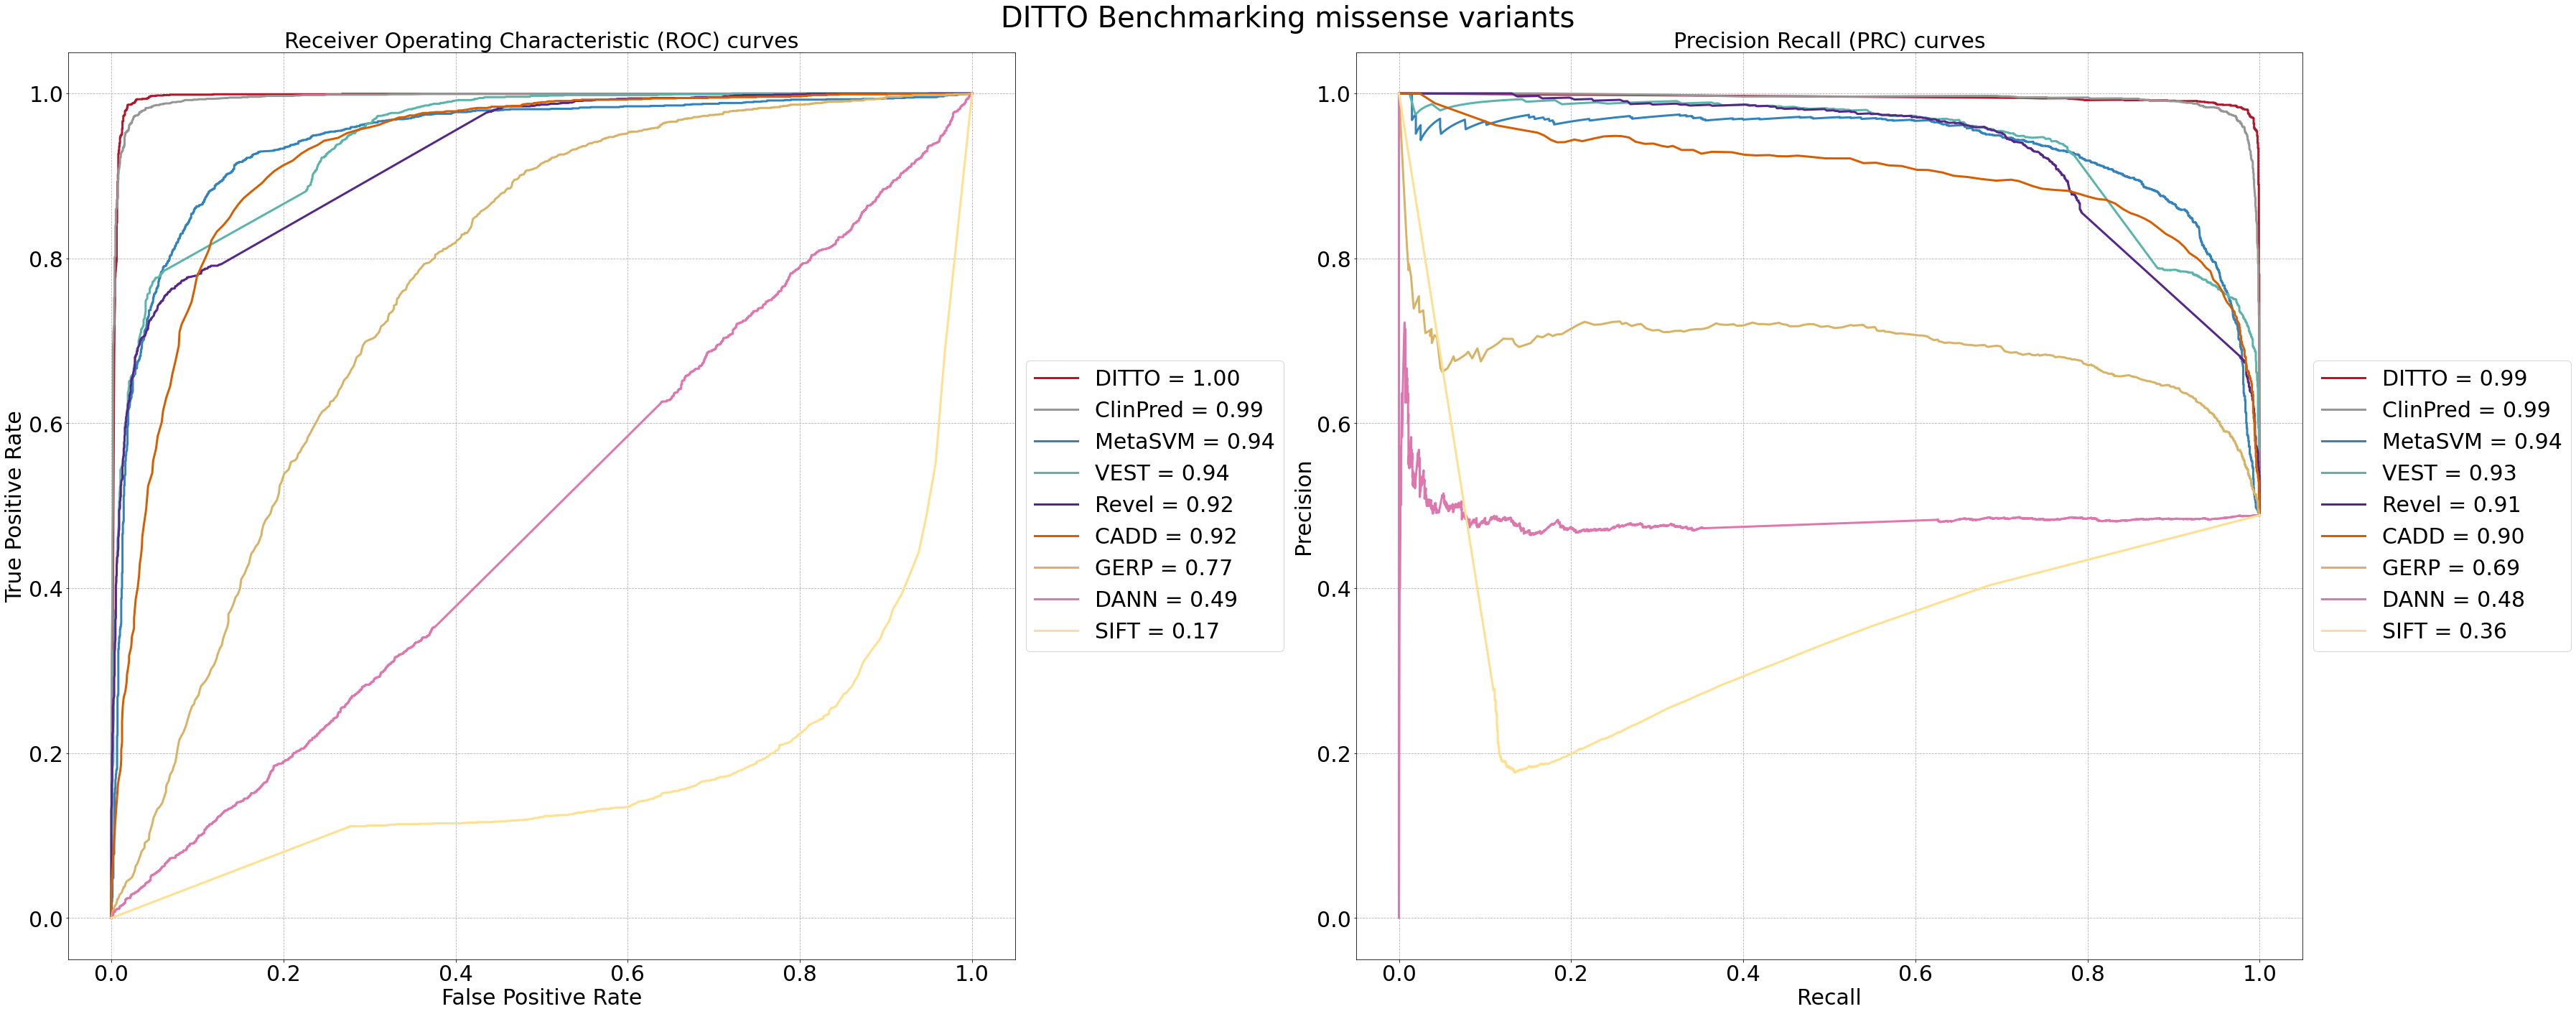

In [48]:

fig, [ax_roc, ax_prc] = plt.subplots(1, 2, figsize=(50, 20))

fig.suptitle(f"DITTO Benchmarking missense variants", fontsize=40)
fsize = 30
ax_roc.tick_params(axis='both', which='major', labelsize=fsize)
ax_prc.tick_params(axis='both', which='major', labelsize=fsize)
ax_roc.set_xlabel("False Positive Rate", fontsize=fsize)
ax_roc.set_ylabel("True Positive Rate", fontsize=fsize)
ax_roc.set_title("Receiver Operating Characteristic (ROC) curves", fontsize=fsize)
ax_roc.grid(linestyle="--")
ax_prc.set_xlabel("Recall", fontsize=fsize)
ax_prc.set_ylabel("Precision", fontsize=fsize)
ax_prc.set_title("Precision Recall (PRC) curves", fontsize=fsize)
ax_prc.grid(linestyle="--")

scores = {}
scores['roc'] = {}
scores['prc'] = {}
scores['f1'] = {}
for name in list(bench.columns):
        index_list = var1[var1.consequence == 'missense_variant'].index
        x = bench[bench.index.isin(index_list)][name].values
        Y_test1 = Y_test[Y_test.index.isin(index_list)].values
        if name in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']:
            y_true = (x-np.min(x))/(np.max(x)-np.min(x))
        else:
            y_true = x
        fpr, tpr, _ = roc_curve(Y_test1, y_true)
        auc = roc_auc_score(Y_test1, y_true, average='weighted')
        auc = "{:.2f}".format(auc)
        scores['roc'][name] = auc
        ax_roc.plot(fpr,tpr,label=str(name)+" = "+str(auc), linewidth=3, c= default_colors[name])
        precision, recall, _ = precision_recall_curve(Y_test1, y_true)
        prc = average_precision_score(Y_test1, y_true, average='weighted')
        prc = "{:.2f}".format(prc)
        scores['prc'][name] = prc
        #f1 = f1_score(Y_test, y_true, sample_weight= weights, average='weighted')
        #scores['f1'][name] = "{:.2f}".format(np.nanmean(f1))

        ax_prc.plot(recall,precision,label=str(name)+" = "+str(prc), linewidth=3, c= default_colors[name])
ax_prc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
ax_roc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
fig.tight_layout()
#plt.savefig(
#            f"/data/project/worthey_lab/projects/experimental_pipelines/tarun/DITTO/data/processed/train_data_3_star/benchmarking/DITTO_ROC_PRC_benchmarking.pdf",
#            format="pdf",
#            dpi=1000,
#            bbox_inches="tight",
#        )


In [49]:
acc_scores_chr = {}
prc_scores_chr = {}
f1_scores_chr = {}
for name in var1.chrom.unique():
    acc_scores_chr[name] = {}
    prc_scores_chr[name] = {}
    f1_scores_chr[name] = {}
    for clf in bench.columns:
        index_list = var1[(var1.chrom == name) & (var1['consequence'] == "missense_variant")].index
        x = bench[bench.index.isin(index_list)][clf].values
        if clf in ['CADD', 'MetaSVM','mutation_assessor','provean','GERP']:
            x_norm = (x-np.min(x))/(np.max(x)-np.min(x))
        else:
            x_norm = x

        acc = accuracy_score(Y_test[index_list],  x_norm.round())
        acc = "{:.2f}".format(acc)
        acc_scores_chr[name][clf] = acc

        prc = precision_score(Y_test[index_list],  x_norm.round())
        prc = "{:.2f}".format(prc)
        prc_scores_chr[name][clf] = prc

        f1 = f1_score(Y_test[index_list],  x_norm.round())
        f1_scores_chr[name][clf] = "{:.2f}".format(f1)


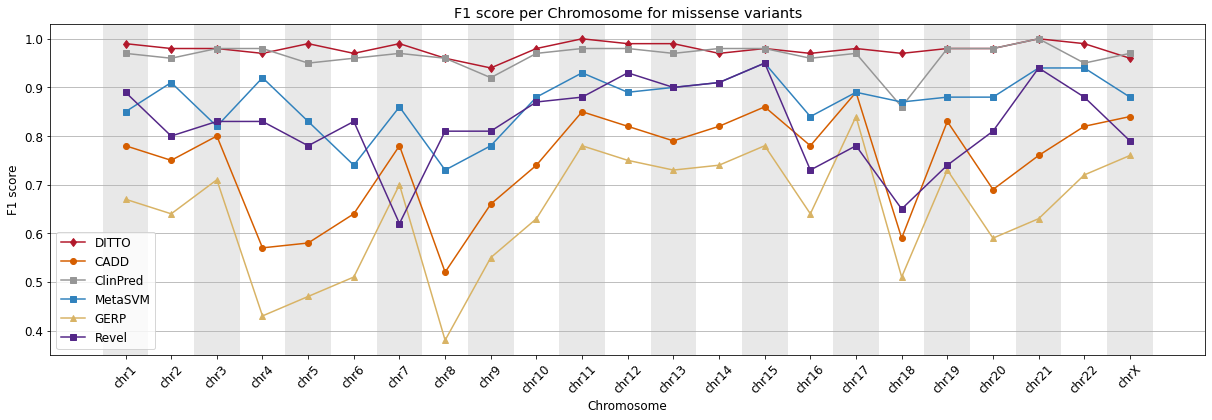

In [51]:
# Extract the chromosome names and values in the specified order
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19',
 'chr20', 'chr21', 'chr22', 'chrX']
CADD_values = [float(f1_scores_chr[chr]['CADD']) for chr in chromosomes]
ClinPred_values = [float(f1_scores_chr[chr]['ClinPred']) for chr in chromosomes]
Revel_values = [float(f1_scores_chr[chr]['Revel']) for chr in chromosomes]
MetaSVM_values = [float(f1_scores_chr[chr]['MetaSVM']) for chr in chromosomes]
GERP_values = [float(f1_scores_chr[chr]['GERP']) for chr in chromosomes]
DITTO_values = [float(f1_scores_chr[chr]['DITTO']) for chr in chromosomes]
# spliceai_values = [float(f1_scores_chr[chr]['spliceai']) for chr in chromosomes]

# Create a Manhattan-style bar plot
plt.figure(figsize=(17, 6))
plt.rcParams.update({'font.size': 12})
plt.plot(chromosomes, DITTO_values, marker='d', label='DITTO', linestyle='-', c= default_colors['DITTO'])
plt.plot(chromosomes, CADD_values, marker='o', label='CADD', linestyle='-', c= default_colors['CADD'])
plt.plot(chromosomes, ClinPred_values, marker='s', label='ClinPred', linestyle='-', c= default_colors['ClinPred'])
plt.plot(chromosomes, MetaSVM_values, marker='s', label='MetaSVM', linestyle='-', c= default_colors['MetaSVM'])
plt.plot(chromosomes, GERP_values, marker='^', label='GERP', linestyle='-', c= default_colors['GERP'])
plt.plot(chromosomes, Revel_values, marker='s', label='Revel', linestyle='-', c= default_colors['Revel'])
# plt.plot(chromosomes, spliceai_values, marker='s', label='spliceai', linestyle='-', c= default_colors['spliceai'])

plt.xlabel('Chromosome')
plt.ylabel('F1 score')
plt.title('F1 score per Chromosome for missense variants')
plt.legend()
plt.grid(axis='y')

# Add shaded rectangles instead of grid lines
ax = plt.gca()
for i in range(len(chromosomes)):
    if i % 2 == 0:  # Shade every other chromosome
        ax.axvspan(i - 0.5, i + 0.5, facecolor='lightgray', alpha=0.5)

plt.xticks(range(len(chromosomes)), chromosomes, rotation=45)  # Set x-axis labels

plt.tight_layout()
plt.show()


In [51]:
var1[(var1['consequence'] =="missense_variant") & (var1['chrom']=="chr9")]['clingen.disease'].value_counts()


nevoid basal cell carcinoma syndrome                                                            14
familial thoracic aortic aneurysm and aortic dissection                                          8
undetermined early-onset epileptic encephalopathy                                                7
citrullinemia type I                                                                             5
Usher syndrome type 2D;nonsyndromic genetic deafness                                             3
melanoma-pancreatic cancer syndrome                                                              3
infantile epilepsy syndrome                                                                      3
complex neurodevelopmental disorder;complex neurodevelopmental disorder                          3
colorectal cancer, susceptibility to, 1                                                          2
tuberous sclerosis 1;tuberous sclerosis                                                          2
malignant 

In [47]:
var1[(var1['consequence'] =="missense_variant") & (var1['chrom']=="chr4")]['clingen.disease'].value_counts()


Wolfram syndrome;Wolfram-like syndrome          6
multiple acyl-CoA dehydrogenase deficiency      3
Brugada syndrome                                2
Ellis-van Creveld syndrome                      2
achondroplasia                                  2
dentinogenesis imperfecta (disease)             2
autosomal dominant polycystic kidney disease    1
mitochondrial DNA depletion syndrome 12         1
Name: clingen.disease, dtype: int64

(4066, 239)


  0%|          | 0/50 [00:00<?, ?it/s]

700/700 [==============================] - 1s 1ms/step


  2%|▏         | 1/50 [00:01<01:21,  1.67s/it]

700/700 [==============================] - 1s 1ms/step


  4%|▍         | 2/50 [00:03<01:16,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


  6%|▌         | 3/50 [00:04<01:16,  1.62s/it]

699/699 [==============================] - 1s 1ms/step


  8%|▊         | 4/50 [00:06<01:14,  1.62s/it]

699/699 [==============================] - 1s 1ms/step


 10%|█         | 5/50 [00:07<01:11,  1.58s/it]

702/702 [==============================] - 1s 1ms/step


 12%|█▏        | 6/50 [00:09<01:07,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 14%|█▍        | 7/50 [00:10<01:05,  1.52s/it]

702/702 [==============================] - 1s 1ms/step


 16%|█▌        | 8/50 [00:12<01:03,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 18%|█▊        | 9/50 [00:13<01:01,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 20%|██        | 10/50 [00:15<01:00,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 22%|██▏       | 11/50 [00:16<00:58,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 24%|██▍       | 12/50 [00:18<00:57,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 26%|██▌       | 13/50 [00:20<00:56,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 28%|██▊       | 14/50 [00:21<00:54,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 30%|███       | 15/50 [00:23<00:53,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 32%|███▏      | 16/50 [00:24<00:52,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 34%|███▍      | 17/50 [00:26<00:50,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 36%|███▌      | 18/50 [00:27<00:48,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 19/50 [00:29<00:46,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 40%|████      | 20/50 [00:30<00:44,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 42%|████▏     | 21/50 [00:32<00:44,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▍     | 22/50 [00:33<00:42,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 46%|████▌     | 23/50 [00:35<00:41,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 48%|████▊     | 24/50 [00:36<00:40,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 50%|█████     | 25/50 [00:38<00:38,  1.56s/it]

707/707 [==============================] - 1s 1ms/step


 52%|█████▏    | 26/50 [00:40<00:37,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 54%|█████▍    | 27/50 [00:41<00:35,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 56%|█████▌    | 28/50 [00:43<00:33,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 58%|█████▊    | 29/50 [00:44<00:32,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 60%|██████    | 30/50 [00:46<00:30,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 62%|██████▏   | 31/50 [00:47<00:29,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▍   | 32/50 [00:49<00:27,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 66%|██████▌   | 33/50 [00:50<00:26,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 68%|██████▊   | 34/50 [00:52<00:25,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 70%|███████   | 35/50 [00:53<00:23,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 72%|███████▏  | 36/50 [00:55<00:21,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 74%|███████▍  | 37/50 [00:56<00:19,  1.53s/it]

701/701 [==============================] - 1s 1ms/step


 76%|███████▌  | 38/50 [00:58<00:18,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 78%|███████▊  | 39/50 [01:00<00:17,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 80%|████████  | 40/50 [01:01<00:15,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 82%|████████▏ | 41/50 [01:03<00:14,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


 84%|████████▍ | 42/50 [01:04<00:12,  1.57s/it]

702/702 [==============================] - 1s 1ms/step


 86%|████████▌ | 43/50 [01:06<00:10,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 88%|████████▊ | 44/50 [01:07<00:09,  1.54s/it]

704/704 [==============================] - 1s 1ms/step


 90%|█████████ | 45/50 [01:09<00:07,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 92%|█████████▏| 46/50 [01:10<00:06,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 94%|█████████▍| 47/50 [01:12<00:04,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 96%|█████████▌| 48/50 [01:13<00:03,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 49/50 [01:15<00:01,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


100%|██████████| 50/50 [01:17<00:00,  1.54s/it]


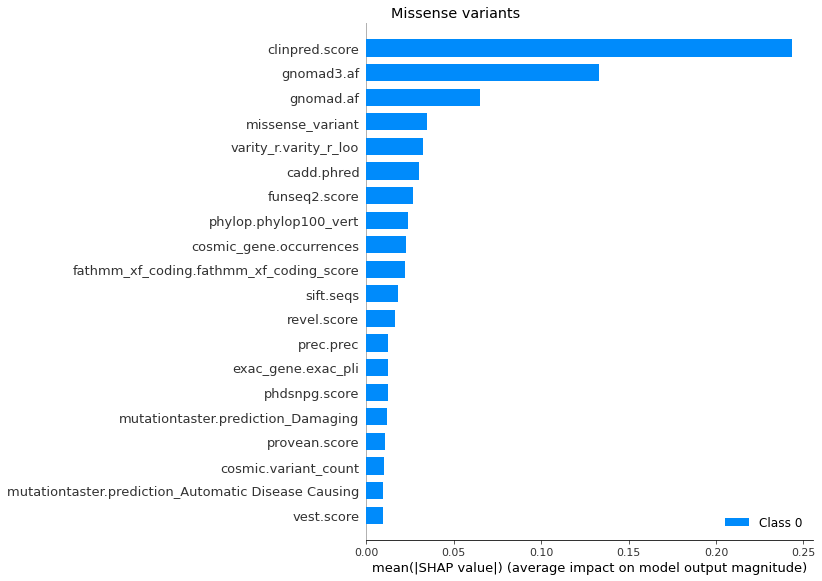

In [88]:
#samples_combined = np.concatenate([background_so, background_x], axis=1)
missense = var1[(var1['consequence'] =="missense_variant")].drop(config_dict["train_cols"]+['DITTO','class'], axis=1).reset_index(drop=True)
print(missense.shape)
background_x = missense.loc[np.random.choice(missense.shape[0], 50, replace=False)]
shap_values = explainer.shap_values(background_x)
shap.summary_plot(shap_values, background_x, background_x.columns, show=False)
plt.title("Missense variants", x=.2)
plt.show()


In [ ]:
conqs = ['missense_variant', 'stop_gained', 'frameshift_truncation',
       'frameshift_elongation', 'intron_variant','intron_variant,splice_site_variant','splice_site_variant']


In [89]:
#samples_combined = np.concatenate([background_so, background_x], axis=1)
#missense = var1[(var1['consequence'] =="splice_site_variant")].drop(config_dict["train_cols"]+['DITTO','class'], axis=1).reset_index(drop=True)
#print(missense.shape)
#background_x = missense
#shap_values = explainer.shap_values(background_x)
#shap.summary_plot(shap_values, background_x, background_x.columns)


(954, 239)


  0%|          | 0/50 [00:00<?, ?it/s]

700/700 [==============================] - 1s 1ms/step


  2%|▏         | 1/50 [00:01<01:17,  1.59s/it]

700/700 [==============================] - 1s 1ms/step


  4%|▍         | 2/50 [00:03<01:14,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


  6%|▌         | 3/50 [00:04<01:13,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 4/50 [00:06<01:10,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 10%|█         | 5/50 [00:07<01:09,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 12%|█▏        | 6/50 [00:09<01:07,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 14%|█▍        | 7/50 [00:10<01:06,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 16%|█▌        | 8/50 [00:12<01:05,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 18%|█▊        | 9/50 [00:13<01:04,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 20%|██        | 10/50 [00:15<01:01,  1.55s/it]

701/701 [==============================] - 1s 1ms/step


 22%|██▏       | 11/50 [00:17<01:00,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 24%|██▍       | 12/50 [00:18<00:59,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 26%|██▌       | 13/50 [00:20<00:57,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 28%|██▊       | 14/50 [00:21<00:56,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 30%|███       | 15/50 [00:23<00:54,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 32%|███▏      | 16/50 [00:24<00:52,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 34%|███▍      | 17/50 [00:26<00:50,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 36%|███▌      | 18/50 [00:27<00:48,  1.53s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 19/50 [00:29<00:47,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 40%|████      | 20/50 [00:30<00:45,  1.53s/it]

702/702 [==============================] - 1s 1ms/step


 42%|████▏     | 21/50 [00:32<00:44,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▍     | 22/50 [00:33<00:43,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 46%|████▌     | 23/50 [00:35<00:41,  1.53s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 24/50 [00:37<00:40,  1.54s/it]

701/701 [==============================] - 1s 1ms/step


 50%|█████     | 25/50 [00:38<00:38,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 52%|█████▏    | 26/50 [00:40<00:37,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 54%|█████▍    | 27/50 [00:41<00:37,  1.62s/it]

702/702 [==============================] - 1s 1ms/step


 56%|█████▌    | 28/50 [00:43<00:35,  1.61s/it]

702/702 [==============================] - 1s 1ms/step


 58%|█████▊    | 29/50 [00:45<00:33,  1.60s/it]

702/702 [==============================] - 1s 1ms/step


 60%|██████    | 30/50 [00:46<00:32,  1.61s/it]

700/700 [==============================] - 1s 1ms/step


 62%|██████▏   | 31/50 [00:48<00:30,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


 64%|██████▍   | 32/50 [00:49<00:28,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 66%|██████▌   | 33/50 [00:51<00:26,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 68%|██████▊   | 34/50 [00:52<00:24,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 70%|███████   | 35/50 [00:54<00:23,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 72%|███████▏  | 36/50 [00:56<00:21,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 74%|███████▍  | 37/50 [00:57<00:20,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


 76%|███████▌  | 38/50 [00:59<00:19,  1.60s/it]

702/702 [==============================] - 1s 1ms/step


 78%|███████▊  | 39/50 [01:00<00:17,  1.60s/it]

700/700 [==============================] - 1s 1ms/step


 80%|████████  | 40/50 [01:02<00:15,  1.60s/it]

702/702 [==============================] - 1s 1ms/step


 82%|████████▏ | 41/50 [01:04<00:14,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 84%|████████▍ | 42/50 [01:05<00:12,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 86%|████████▌ | 43/50 [01:07<00:10,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 88%|████████▊ | 44/50 [01:08<00:09,  1.57s/it]

702/702 [==============================] - 1s 1ms/step


 90%|█████████ | 45/50 [01:10<00:07,  1.56s/it]

700/700 [==============================] - 1s 1ms/step


 92%|█████████▏| 46/50 [01:11<00:06,  1.57s/it]

700/700 [==============================] - 1s 1ms/step


 94%|█████████▍| 47/50 [01:13<00:04,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 96%|█████████▌| 48/50 [01:14<00:03,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 98%|█████████▊| 49/50 [01:16<00:01,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


100%|██████████| 50/50 [01:17<00:00,  1.56s/it]


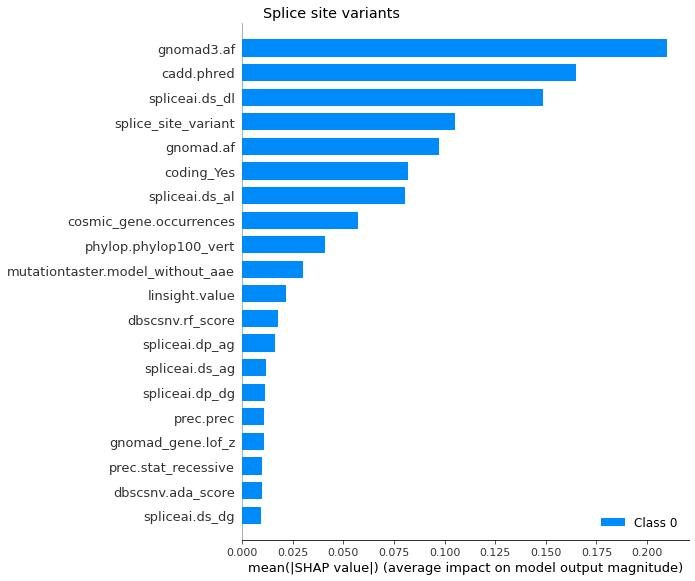

In [90]:
#samples_combined = np.concatenate([background_so, background_x], axis=1)
missense = var1[(var1['consequence'].isin(["intron_variant,splice_site_variant","splice_site_variant"]))].drop(config_dict["train_cols"]+['DITTO','class'], axis=1).reset_index(drop=True)
print(missense.shape)
background_x = missense.loc[np.random.choice(missense.shape[0], 50, replace=False)]
shap_values = explainer.shap_values(background_x)
shap.summary_plot(shap_values, background_x, background_x.columns, show=False)
plt.title("Splice site variants", x=.2)
plt.show()


In [91]:
#samples_combined = np.concatenate([background_so, background_x], axis=1)
#missense = var1[(var1['consequence'] =="intron_variant,splice_site_variant")].drop(config_dict["train_cols"]+['DITTO','class'], axis=1).reset_index(drop=True)
#print(missense.shape)
#background_x = missense.loc[np.random.choice(missense.shape[0], 5, replace=False)]
#shap_values = explainer.shap_values(background_x)
#shap.summary_plot(shap_values, background_x, background_x.columns, show=False)
#plt.title("Intronic Splice site", x=.2)
#plt.show()


(1944, 239)


  0%|          | 0/50 [00:00<?, ?it/s]

700/700 [==============================] - 1s 1ms/step


  2%|▏         | 1/50 [00:01<01:13,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


  4%|▍         | 2/50 [00:02<01:11,  1.48s/it]

700/700 [==============================] - 1s 1ms/step


  6%|▌         | 3/50 [00:04<01:09,  1.47s/it]

700/700 [==============================] - 1s 1ms/step


  8%|▊         | 4/50 [00:05<01:07,  1.47s/it]

699/699 [==============================] - 1s 1ms/step


 10%|█         | 5/50 [00:07<01:06,  1.47s/it]

699/699 [==============================] - 1s 1ms/step


 12%|█▏        | 6/50 [00:08<01:04,  1.47s/it]

700/700 [==============================] - 1s 1ms/step


 14%|█▍        | 7/50 [00:10<01:04,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 16%|█▌        | 8/50 [00:11<01:03,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 18%|█▊        | 9/50 [00:13<01:01,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 20%|██        | 10/50 [00:14<00:59,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 22%|██▏       | 11/50 [00:16<00:58,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 24%|██▍       | 12/50 [00:17<00:56,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 26%|██▌       | 13/50 [00:19<00:55,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 28%|██▊       | 14/50 [00:20<00:54,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 30%|███       | 15/50 [00:22<00:52,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 32%|███▏      | 16/50 [00:23<00:51,  1.50s/it]

702/702 [==============================] - 1s 1ms/step


 34%|███▍      | 17/50 [00:25<00:49,  1.49s/it]

703/703 [==============================] - 1s 1ms/step


 36%|███▌      | 18/50 [00:26<00:47,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 38%|███▊      | 19/50 [00:28<00:45,  1.48s/it]

699/699 [==============================] - 1s 1ms/step


 40%|████      | 20/50 [00:29<00:44,  1.48s/it]

700/700 [==============================] - 1s 1ms/step


 42%|████▏     | 21/50 [00:31<00:42,  1.47s/it]

700/700 [==============================] - 1s 1ms/step


 44%|████▍     | 22/50 [00:32<00:41,  1.47s/it]

700/700 [==============================] - 1s 1ms/step


 46%|████▌     | 23/50 [00:34<00:40,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 48%|████▊     | 24/50 [00:35<00:38,  1.50s/it]

701/701 [==============================] - 1s 1ms/step


 50%|█████     | 25/50 [00:37<00:37,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 52%|█████▏    | 26/50 [00:38<00:35,  1.48s/it]

701/701 [==============================] - 1s 1ms/step


 54%|█████▍    | 27/50 [00:40<00:33,  1.48s/it]

704/704 [==============================] - 1s 1ms/step


 56%|█████▌    | 28/50 [00:41<00:32,  1.48s/it]

700/700 [==============================] - 1s 1ms/step


 58%|█████▊    | 29/50 [00:43<00:31,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 60%|██████    | 30/50 [00:44<00:30,  1.51s/it]

702/702 [==============================] - 1s 1ms/step


 62%|██████▏   | 31/50 [00:46<00:28,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 64%|██████▍   | 32/50 [00:47<00:26,  1.49s/it]

702/702 [==============================] - 1s 1ms/step


 66%|██████▌   | 33/50 [00:49<00:25,  1.49s/it]

700/700 [==============================] - 1s 1ms/step


 68%|██████▊   | 34/50 [00:50<00:24,  1.51s/it]

700/700 [==============================] - 1s 1ms/step


 70%|███████   | 35/50 [00:52<00:22,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 72%|███████▏  | 36/50 [00:53<00:21,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 74%|███████▍  | 37/50 [00:55<00:19,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 76%|███████▌  | 38/50 [00:56<00:17,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 78%|███████▊  | 39/50 [00:58<00:16,  1.48s/it]

700/700 [==============================] - 1s 1ms/step


 80%|████████  | 40/50 [00:59<00:14,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 82%|████████▏ | 41/50 [01:01<00:13,  1.54s/it]

702/702 [==============================] - 1s 1ms/step


 84%|████████▍ | 42/50 [01:03<00:12,  1.61s/it]

703/703 [==============================] - 1s 1ms/step


 86%|████████▌ | 43/50 [01:04<00:11,  1.58s/it]

701/701 [==============================] - 1s 1ms/step


 88%|████████▊ | 44/50 [01:06<00:09,  1.55s/it]

700/700 [==============================] - 1s 1ms/step


 90%|█████████ | 45/50 [01:07<00:07,  1.54s/it]

700/700 [==============================] - 1s 1ms/step


 92%|█████████▏| 46/50 [01:09<00:06,  1.52s/it]

700/700 [==============================] - 1s 1ms/step


 94%|█████████▍| 47/50 [01:10<00:04,  1.53s/it]

704/704 [==============================] - 1s 1ms/step


 96%|█████████▌| 48/50 [01:12<00:03,  1.59s/it]

702/702 [==============================] - 1s 1ms/step


 98%|█████████▊| 49/50 [01:13<00:01,  1.58s/it]

701/701 [==============================] - 1s 1ms/step


100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


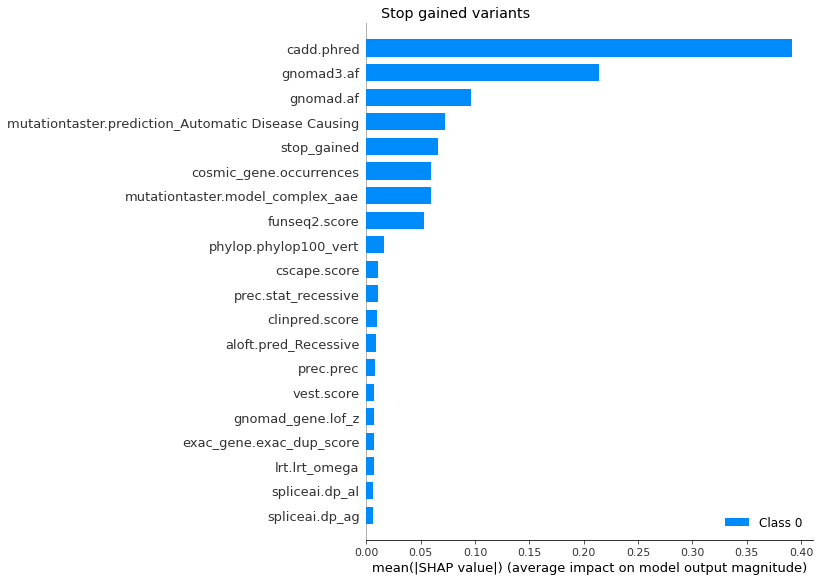

In [92]:
#samples_combined = np.concatenate([background_so, background_x], axis=1)
missense = var1[(var1['consequence'] =="stop_gained")].drop(config_dict["train_cols"]+['DITTO','class'], axis=1).reset_index(drop=True)
print(missense.shape)
background_x = missense.loc[np.random.choice(missense.shape[0], 50, replace=False)]
shap_values = explainer.shap_values(background_x)
shap.summary_plot(shap_values, background_x, background_x.columns, show=False)
plt.title("Stop gained variants", x=.2)
plt.show()


(2807, 239)


  0%|          | 0/50 [00:00<?, ?it/s]

698/698 [==============================] - 1s 1ms/step


  2%|▏         | 1/50 [00:01<01:17,  1.58s/it]

698/698 [==============================] - 1s 1ms/step


  4%|▍         | 2/50 [00:03<01:13,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


  6%|▌         | 3/50 [00:04<01:10,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


  8%|▊         | 4/50 [00:06<01:08,  1.50s/it]

700/700 [==============================] - 1s 1ms/step


 10%|█         | 5/50 [00:07<01:06,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 12%|█▏        | 6/50 [00:09<01:06,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 14%|█▍        | 7/50 [00:10<01:04,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 16%|█▌        | 8/50 [00:12<01:03,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 18%|█▊        | 9/50 [00:13<01:01,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 20%|██        | 10/50 [00:15<01:00,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 22%|██▏       | 11/50 [00:16<00:58,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 24%|██▍       | 12/50 [00:18<00:57,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 26%|██▌       | 13/50 [00:19<00:57,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 28%|██▊       | 14/50 [00:21<00:56,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 30%|███       | 15/50 [00:22<00:54,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 32%|███▏      | 16/50 [00:24<00:52,  1.54s/it]

698/698 [==============================] - 1s 1ms/step


 34%|███▍      | 17/50 [00:25<00:51,  1.56s/it]

698/698 [==============================] - 1s 1ms/step


 36%|███▌      | 18/50 [00:27<00:49,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 38%|███▊      | 19/50 [00:28<00:47,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 40%|████      | 20/50 [00:30<00:45,  1.52s/it]

699/699 [==============================] - 1s 1ms/step


 42%|████▏     | 21/50 [00:31<00:43,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 44%|████▍     | 22/50 [00:33<00:42,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 46%|████▌     | 23/50 [00:34<00:40,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 48%|████▊     | 24/50 [00:36<00:39,  1.51s/it]

698/698 [==============================] - 1s 1ms/step


 50%|█████     | 25/50 [00:37<00:37,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 52%|█████▏    | 26/50 [00:39<00:36,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 54%|█████▍    | 27/50 [00:41<00:34,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 56%|█████▌    | 28/50 [00:42<00:33,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 58%|█████▊    | 29/50 [00:43<00:31,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 60%|██████    | 30/50 [00:45<00:29,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 62%|██████▏   | 31/50 [00:47<00:28,  1.51s/it]

699/699 [==============================] - 1s 1ms/step


 64%|██████▍   | 32/50 [00:48<00:27,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 66%|██████▌   | 33/50 [00:49<00:25,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 68%|██████▊   | 34/50 [00:51<00:23,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 70%|███████   | 35/50 [00:52<00:22,  1.49s/it]

699/699 [==============================] - 1s 1ms/step


 72%|███████▏  | 36/50 [00:54<00:20,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


 74%|███████▍  | 37/50 [00:55<00:19,  1.48s/it]

698/698 [==============================] - 1s 1ms/step


 76%|███████▌  | 38/50 [00:57<00:17,  1.48s/it]

698/698 [==============================] - 1s 1ms/step


 78%|███████▊  | 39/50 [00:58<00:16,  1.50s/it]

699/699 [==============================] - 1s 1ms/step


 80%|████████  | 40/50 [01:00<00:15,  1.55s/it]

702/702 [==============================] - 1s 1ms/step


 82%|████████▏ | 41/50 [01:02<00:14,  1.58s/it]

700/700 [==============================] - 1s 1ms/step


 84%|████████▍ | 42/50 [01:03<00:12,  1.57s/it]

699/699 [==============================] - 1s 1ms/step


 86%|████████▌ | 43/50 [01:05<00:10,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 88%|████████▊ | 44/50 [01:06<00:09,  1.55s/it]

698/698 [==============================] - 1s 1ms/step


 90%|█████████ | 45/50 [01:08<00:07,  1.53s/it]

698/698 [==============================] - 1s 1ms/step


 92%|█████████▏| 46/50 [01:09<00:06,  1.52s/it]

701/701 [==============================] - 1s 1ms/step


 94%|█████████▍| 47/50 [01:11<00:04,  1.51s/it]

701/701 [==============================] - 1s 1ms/step


 96%|█████████▌| 48/50 [01:12<00:02,  1.50s/it]

698/698 [==============================] - 1s 1ms/step


 98%|█████████▊| 49/50 [01:14<00:01,  1.49s/it]

698/698 [==============================] - 1s 1ms/step


100%|██████████| 50/50 [01:15<00:00,  1.52s/it]


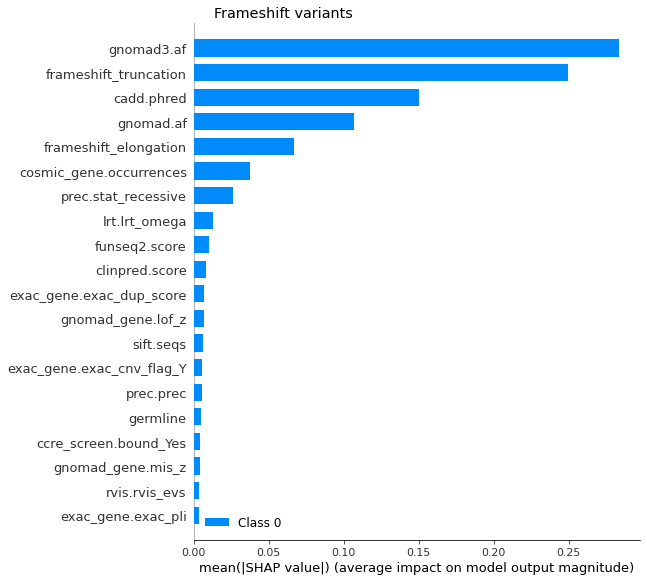

In [93]:
#samples_combined = np.concatenate([background_so, background_x], axis=1)
missense = var1[(var1['consequence'].isin(['frameshift_truncation','frameshift_elongation']))].drop(config_dict["train_cols"]+['DITTO','class'], axis=1).reset_index(drop=True)
print(missense.shape)
background_x = missense.loc[np.random.choice(missense.shape[0], 50, replace=False)]
shap_values = explainer.shap_values(background_x)
shap.summary_plot(shap_values, background_x, background_x.columns, show=False)
plt.title("Frameshift variants", x=.2)
plt.show()


In [45]:
var1[['mavedb.score','DITTO']].head()


mavedb.score  DITTO
0      0.867714    1.0
1      0.867714    1.0
2      0.867714    1.0
3      0.867714    1.0
4      0.867714    1.0

In [49]:
var1[['mavedb.score','DITTO']].dtypes


mavedb.score    float64
DITTO           float32
dtype: object

In [68]:
var1.shape


(37027, 256)

In [64]:
sc_data = var1[['mavedb.score','DITTO']].drop_duplicates().reset_index(drop=True)
sc_data.head()


mavedb.score  DITTO
0      0.867714    1.0
1      1.085198    1.0
2      0.873427    1.0
3     -0.006227    1.0
4      0.156953    1.0

In [69]:
sc_data.shape


(9930, 2)

In [67]:
sc_data['mavedb.score'].value_counts()


mavedb.score
 0.867714    9889
 1.156741       1
 1.080369       1
 1.130410       1
 1.051897       1
 0.993691       1
 0.993719       1
 1.003396       1
 1.057490       1
 0.417562       1
 1.060959       1
 1.085198       1
 1.132874       1
 1.249492       1
 1.037391       1
 1.003263       1
 0.940107       1
 0.981642       1
 1.392515       1
 1.055863       1
-0.004865       1
 0.107000       1
 0.522931       1
 0.009492       1
 0.873427       1
-0.006227       1
 0.156953       1
 0.031064       1
 0.090229       1
 0.719476       1
 0.407828       1
-0.062169       1
 0.167416       1
 0.267447       1
 1.156291       1
 0.162758       1
 1.137468       1
 0.330857       1
 0.167144       1
 1.263799       1
 1.025690       1
 0.866452       1
Name: count, dtype: int64

<Axes: ylabel='Density'>

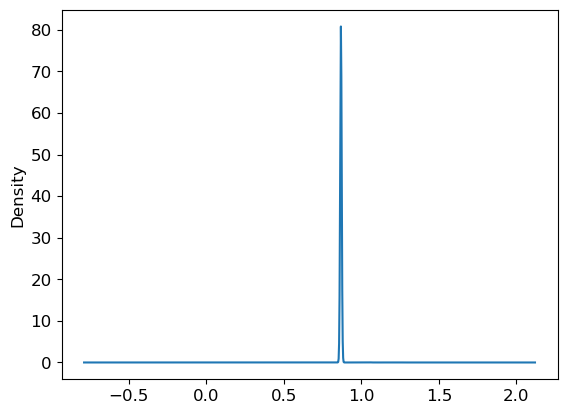

In [66]:
sc_data['mavedb.score'].plot(kind='kde')


<Axes: xlabel='DITTO', ylabel='mavedb.score'>

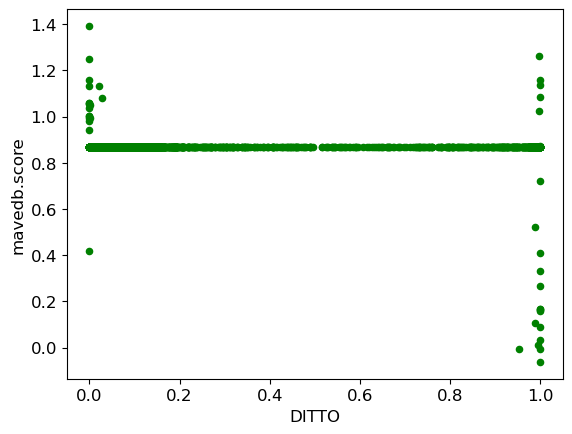

In [65]:
sc_data.plot(kind='scatter', x='DITTO', y='mavedb.score', color='g')


In [90]:
var1.consequence.value_counts()


consequence
synonymous_variant                                                                  8683
intron_variant                                                                      6928
missense_variant                                                                    4066
processed_transcript                                                                2703
stop_gained                                                                         1944
frameshift_truncation                                                               1907
NMD_transcript_variant,3_prime_UTR_variant                                          1405
intron_variant,splice_site_variant                                                   919
frameshift_elongation                                                                900
intron_variant,NMD_transcript_variant                                                647
2kb_downstream_variant                                                               624
2kb_upstr

In [89]:
var1[var1.consequence == 'stop_gained'].shape


(1944, 256)

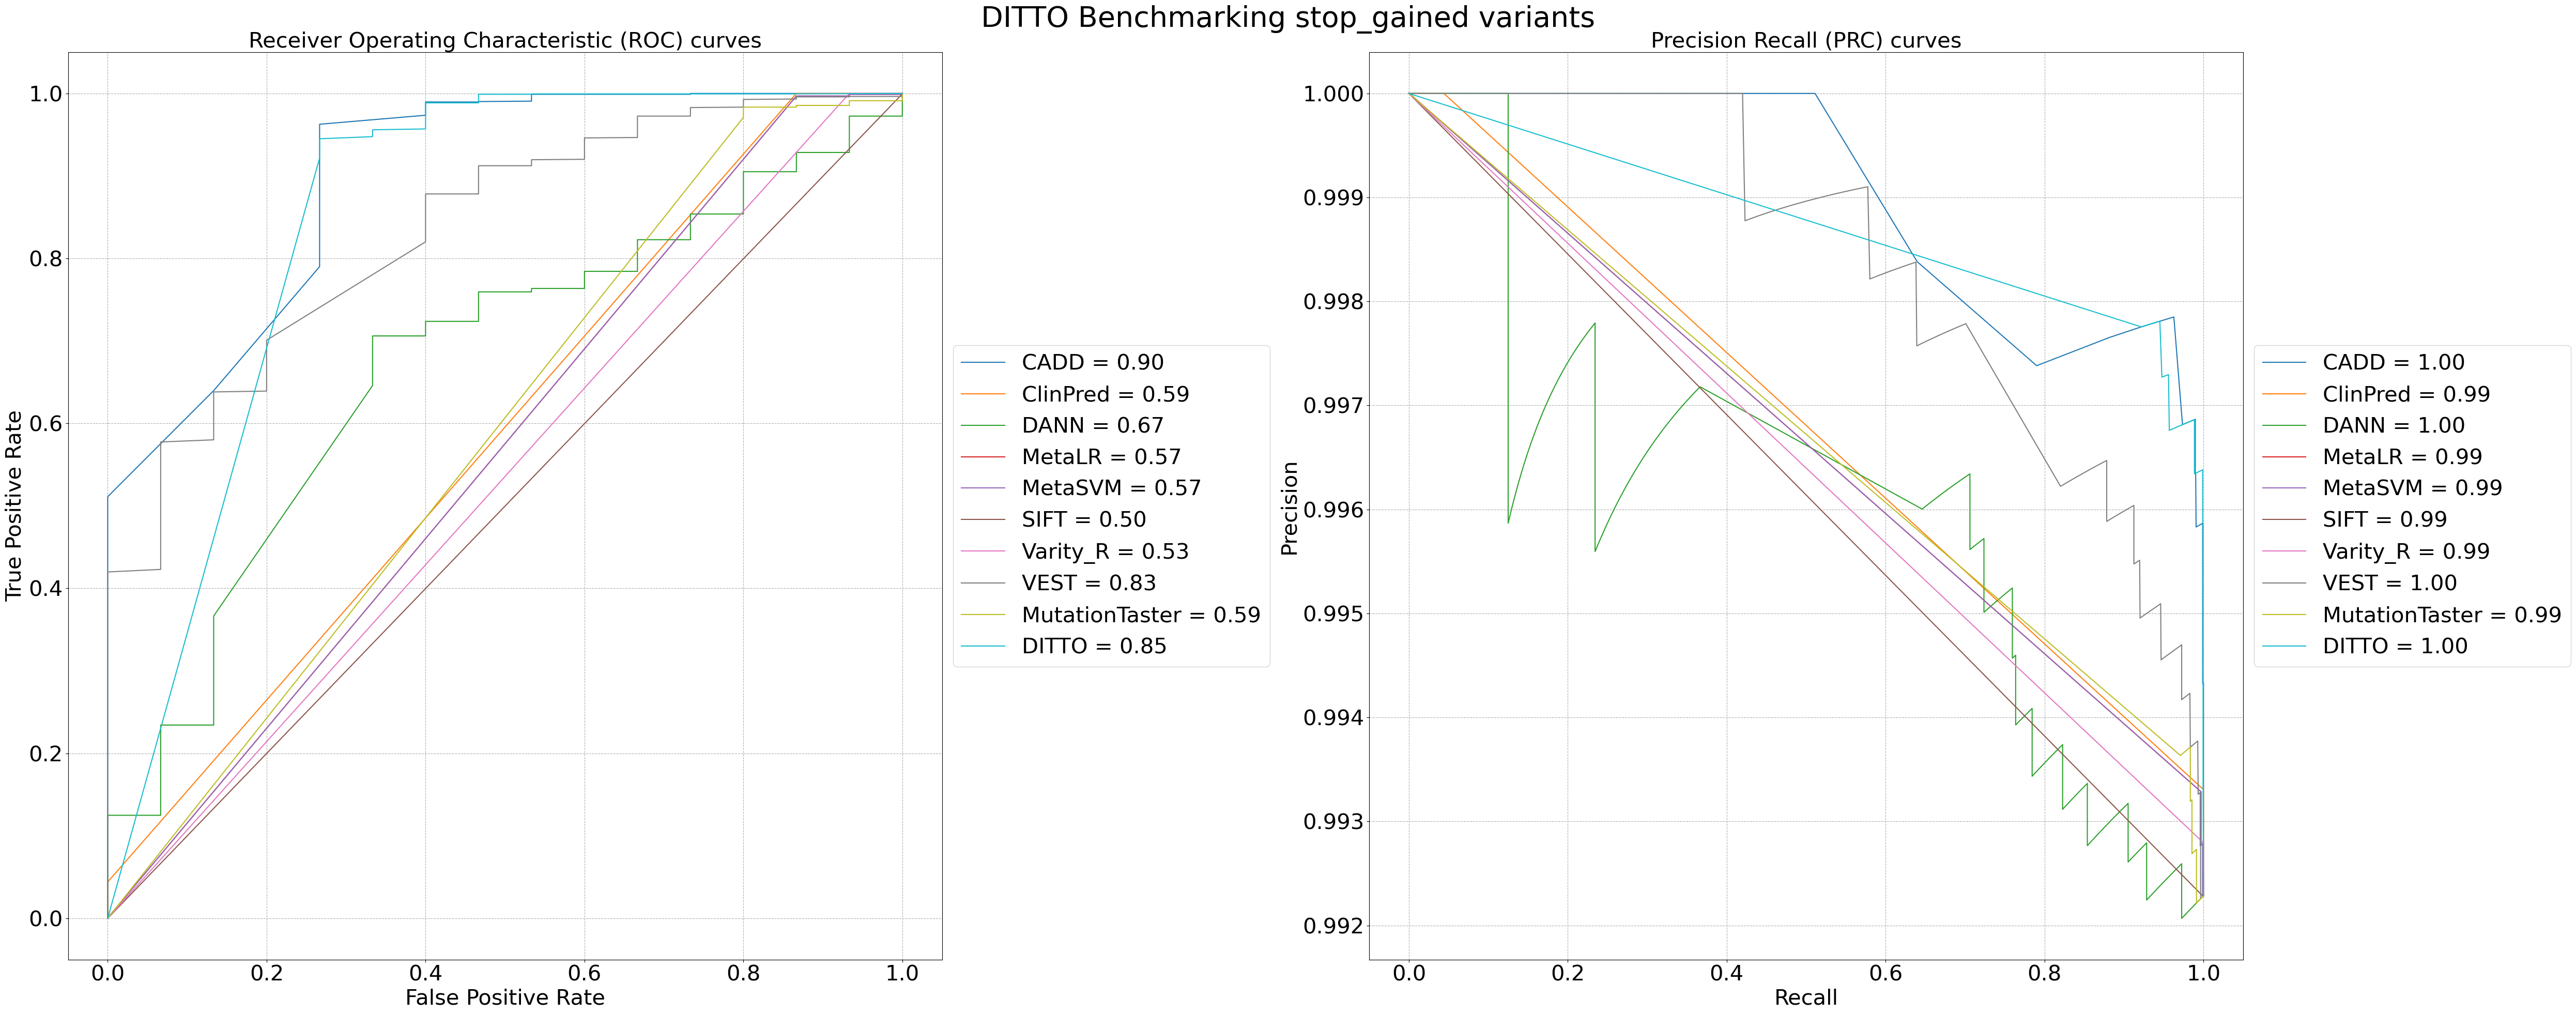

In [92]:

fig, [ax_roc, ax_prc] = plt.subplots(1, 2, figsize=(50, 20))

fig.suptitle(f"DITTO Benchmarking stop_gained variants", fontsize=40)
fsize = 30
ax_roc.tick_params(axis='both', which='major', labelsize=fsize)
ax_prc.tick_params(axis='both', which='major', labelsize=fsize)
ax_roc.set_xlabel("False Positive Rate", fontsize=fsize)
ax_roc.set_ylabel("True Positive Rate", fontsize=fsize)
ax_roc.set_title("Receiver Operating Characteristic (ROC) curves", fontsize=fsize)
ax_roc.grid(linestyle="--")
ax_prc.set_xlabel("Recall", fontsize=fsize)
ax_prc.set_ylabel("Precision", fontsize=fsize)
ax_prc.set_title("Precision Recall (PRC) curves", fontsize=fsize)
ax_prc.grid(linestyle="--")

scores = {}
scores['roc'] = {}
scores['prc'] = {}
scores['f1'] = {}
for name in list(bench.columns):
        index_list = var1[var1.consequence == 'stop_gained'].index
        x = bench[bench.index.isin(index_list)][name].values
        Y_test = Y_test1[Y_test1.index.isin(index_list)].values
        if name == 'CADD' or name == 'MetaSVM':
            y_true = (x-np.min(x))/(np.max(x)-np.min(x))
        else:
            y_true = x
        fpr, tpr, _ = roc_curve(Y_test, y_true)
        auc = roc_auc_score(Y_test, y_true, average='weighted')
        auc = "{:.2f}".format(auc)
        scores['roc'][name] = auc
        ax_roc.plot(fpr,tpr,label=str(name)+" = "+str(auc))
        precision, recall, _ = precision_recall_curve(Y_test, y_true)
        prc = average_precision_score(Y_test, y_true, average='weighted')
        prc = "{:.2f}".format(prc)
        scores['prc'][name] = prc
        #f1 = f1_score(Y_test, y_true, sample_weight= weights, average='weighted')
        #scores['f1'][name] = "{:.2f}".format(np.nanmean(f1))

        ax_prc.plot(recall,precision,label=str(name)+" = "+str(prc))
ax_prc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
ax_roc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
fig.tight_layout()
#plt.savefig(
#            f"/data/project/worthey_lab/projects/experimental_pipelines/tarun/DITTO/data/processed/train_data_3_star/benchmarking/DITTO_ROC_PRC_benchmarking.pdf",
#            format="pdf",
#            dpi=1000,
#            bbox_inches="tight",
#        )


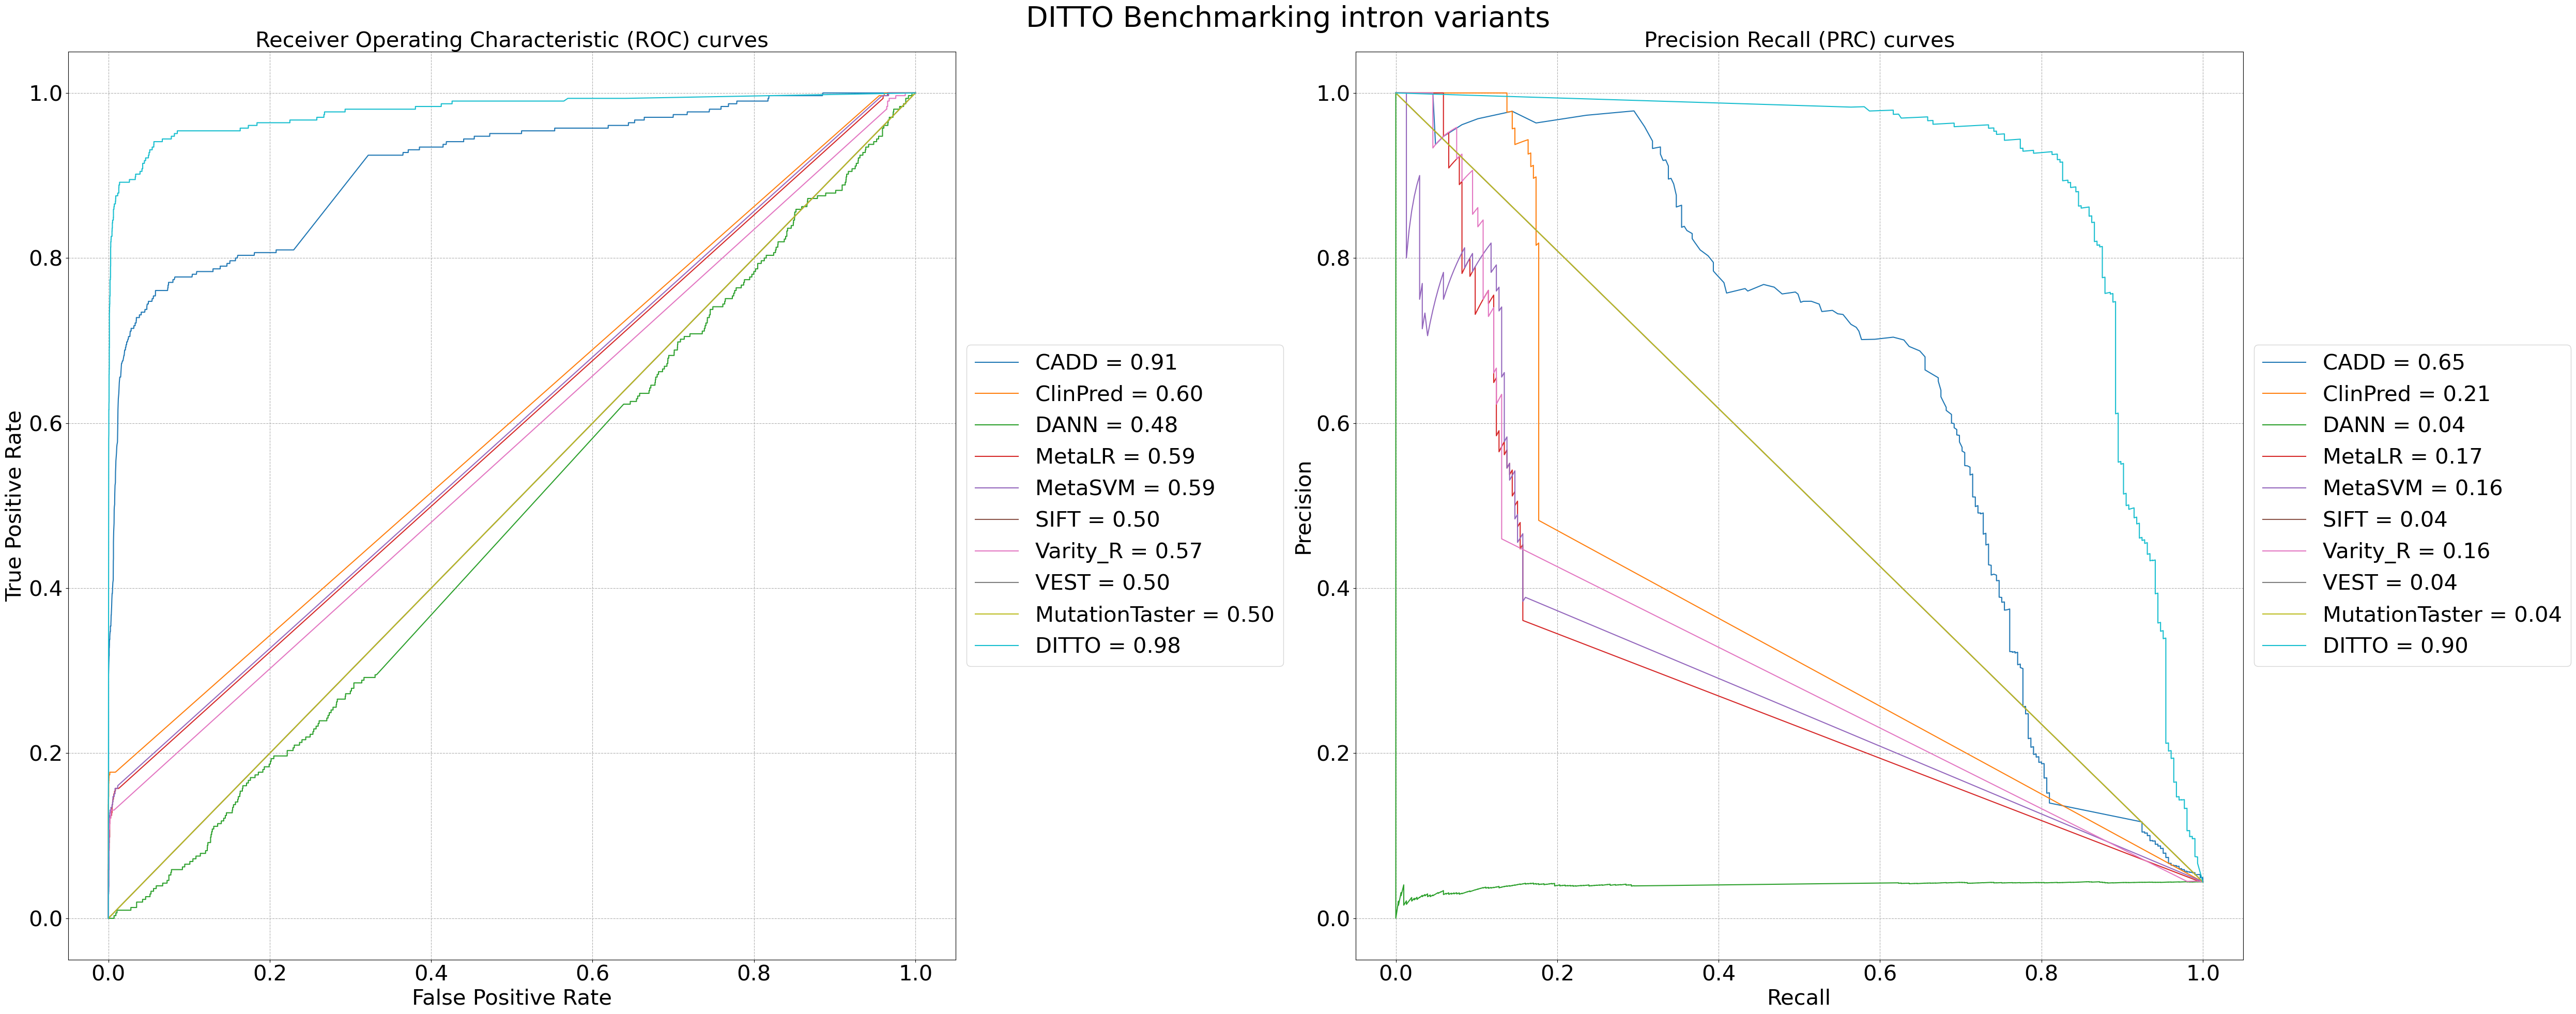

In [93]:

fig, [ax_roc, ax_prc] = plt.subplots(1, 2, figsize=(50, 20))

fig.suptitle(f"DITTO Benchmarking intron variants", fontsize=40)
fsize = 30
ax_roc.tick_params(axis='both', which='major', labelsize=fsize)
ax_prc.tick_params(axis='both', which='major', labelsize=fsize)
ax_roc.set_xlabel("False Positive Rate", fontsize=fsize)
ax_roc.set_ylabel("True Positive Rate", fontsize=fsize)
ax_roc.set_title("Receiver Operating Characteristic (ROC) curves", fontsize=fsize)
ax_roc.grid(linestyle="--")
ax_prc.set_xlabel("Recall", fontsize=fsize)
ax_prc.set_ylabel("Precision", fontsize=fsize)
ax_prc.set_title("Precision Recall (PRC) curves", fontsize=fsize)
ax_prc.grid(linestyle="--")

scores = {}
scores['roc'] = {}
scores['prc'] = {}
scores['f1'] = {}
for name in list(bench.columns):
        index_list = var1[var1.consequence == 'intron_variant'].index
        x = bench[bench.index.isin(index_list)][name].values
        Y_test = Y_test1[Y_test1.index.isin(index_list)].values
        if name == 'CADD' or name == 'MetaSVM':
            y_true = (x-np.min(x))/(np.max(x)-np.min(x))
        else:
            y_true = x
        fpr, tpr, _ = roc_curve(Y_test, y_true)
        auc = roc_auc_score(Y_test, y_true, average='weighted')
        auc = "{:.2f}".format(auc)
        scores['roc'][name] = auc
        ax_roc.plot(fpr,tpr,label=str(name)+" = "+str(auc))
        precision, recall, _ = precision_recall_curve(Y_test, y_true)
        prc = average_precision_score(Y_test, y_true, average='weighted')
        prc = "{:.2f}".format(prc)
        scores['prc'][name] = prc
        #f1 = f1_score(Y_test, y_true, sample_weight= weights, average='weighted')
        #scores['f1'][name] = "{:.2f}".format(np.nanmean(f1))

        ax_prc.plot(recall,precision,label=str(name)+" = "+str(prc))
ax_prc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
ax_roc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
fig.tight_layout()
#plt.savefig(
#            f"/data/project/worthey_lab/projects/experimental_pipelines/tarun/DITTO/data/processed/train_data_3_star/benchmarking/DITTO_ROC_PRC_benchmarking.pdf",
#            format="pdf",
#            dpi=1000,
#            bbox_inches="tight",
#        )


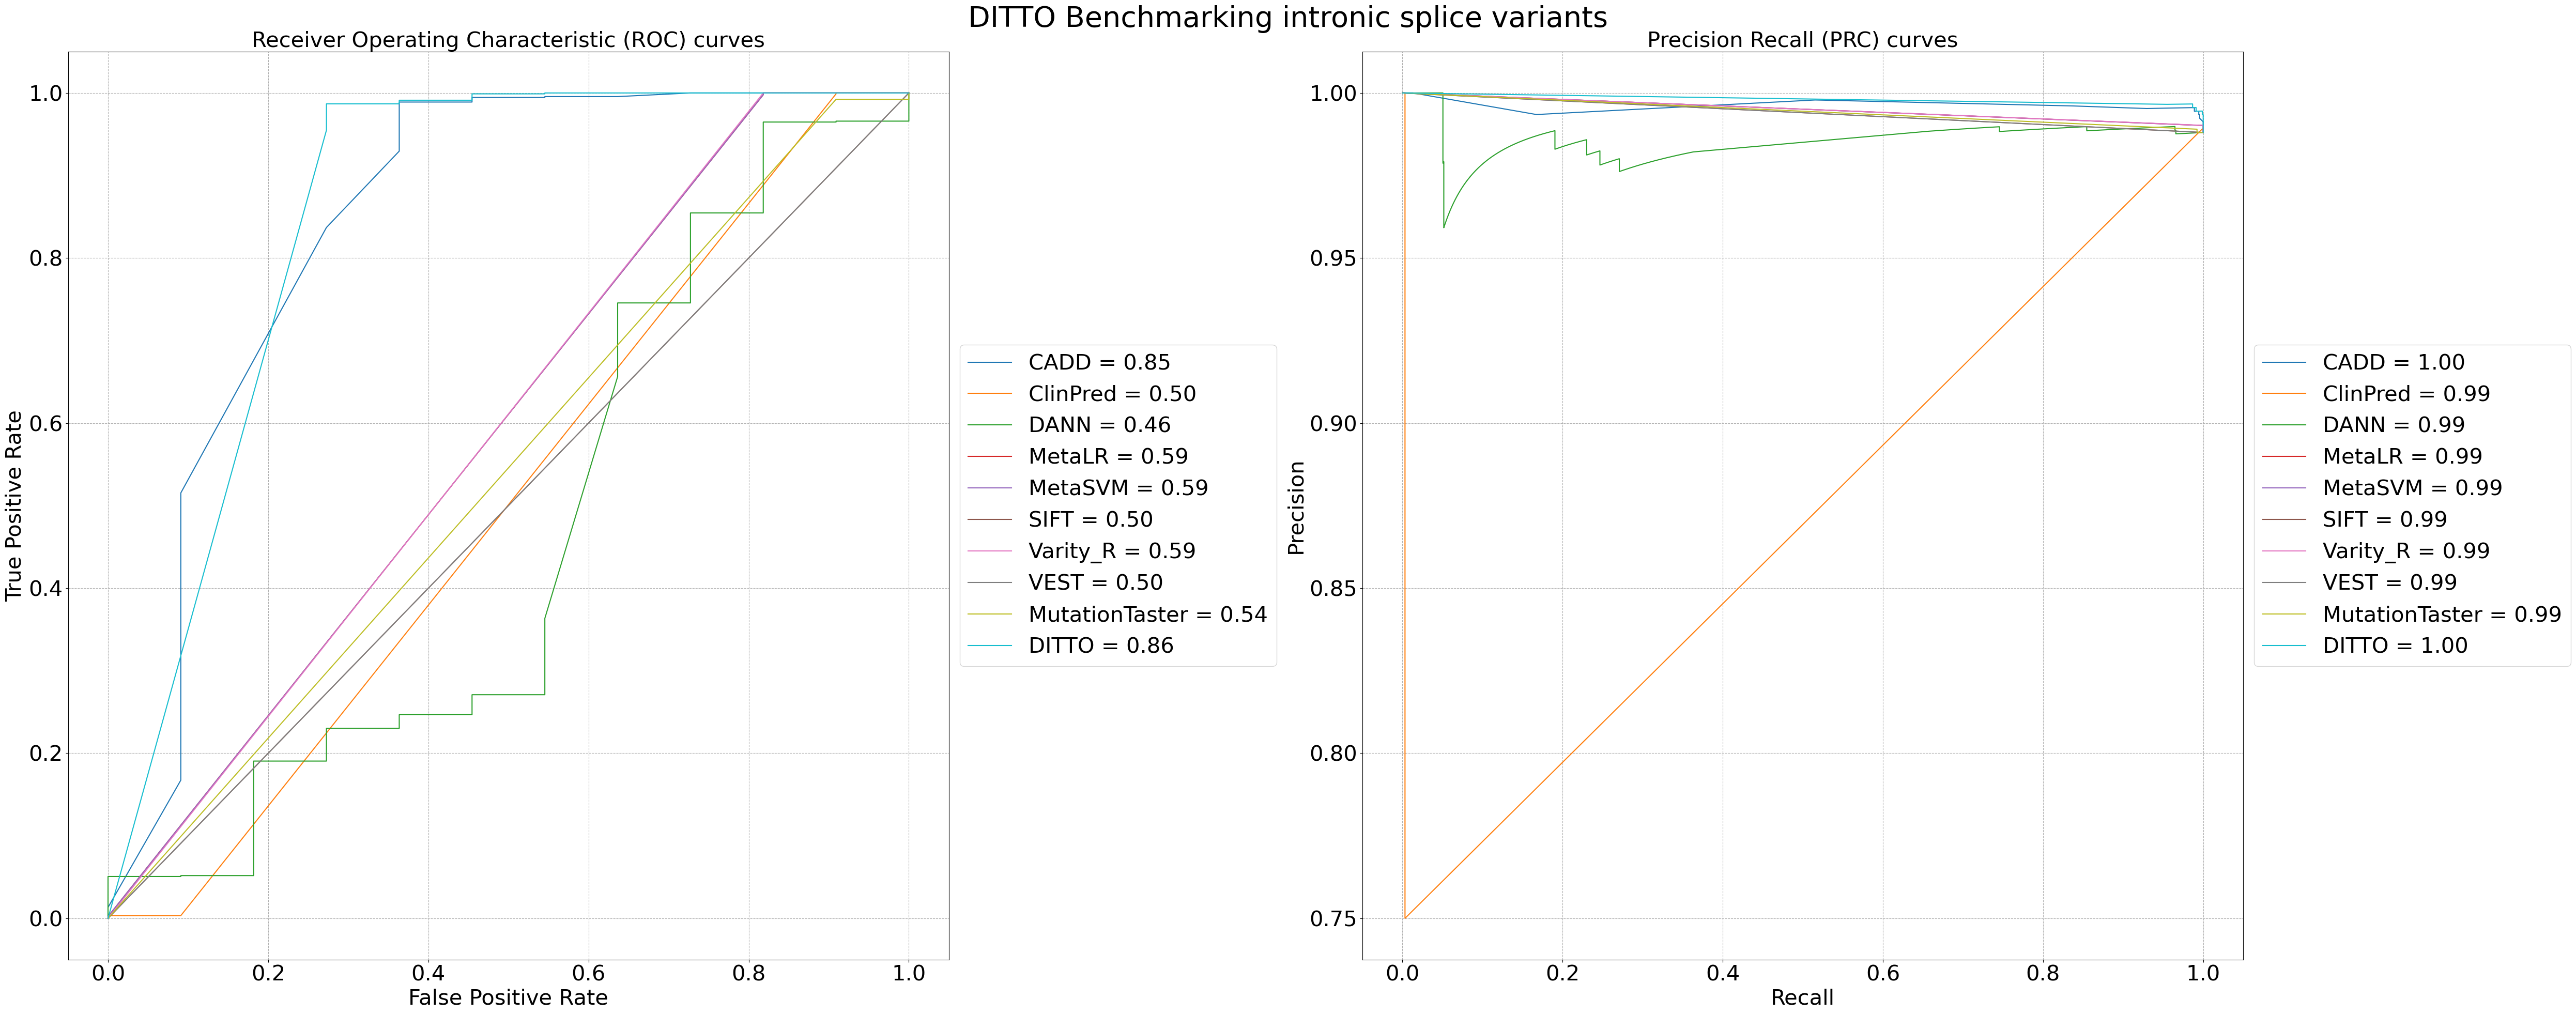

In [94]:

fig, [ax_roc, ax_prc] = plt.subplots(1, 2, figsize=(50, 20))

fig.suptitle(f"DITTO Benchmarking intronic splice variants", fontsize=40)
fsize = 30
ax_roc.tick_params(axis='both', which='major', labelsize=fsize)
ax_prc.tick_params(axis='both', which='major', labelsize=fsize)
ax_roc.set_xlabel("False Positive Rate", fontsize=fsize)
ax_roc.set_ylabel("True Positive Rate", fontsize=fsize)
ax_roc.set_title("Receiver Operating Characteristic (ROC) curves", fontsize=fsize)
ax_roc.grid(linestyle="--")
ax_prc.set_xlabel("Recall", fontsize=fsize)
ax_prc.set_ylabel("Precision", fontsize=fsize)
ax_prc.set_title("Precision Recall (PRC) curves", fontsize=fsize)
ax_prc.grid(linestyle="--")

scores = {}
scores['roc'] = {}
scores['prc'] = {}
scores['f1'] = {}
for name in list(bench.columns):
        index_list = var1[var1.consequence == 'intron_variant,splice_site_variant'].index
        x = bench[bench.index.isin(index_list)][name].values
        Y_test = Y_test1[Y_test1.index.isin(index_list)].values
        if name == 'CADD' or name == 'MetaSVM':
            y_true = (x-np.min(x))/(np.max(x)-np.min(x))
        else:
            y_true = x
        fpr, tpr, _ = roc_curve(Y_test, y_true)
        auc = roc_auc_score(Y_test, y_true, average='weighted')
        auc = "{:.2f}".format(auc)
        scores['roc'][name] = auc
        ax_roc.plot(fpr,tpr,label=str(name)+" = "+str(auc))
        precision, recall, _ = precision_recall_curve(Y_test, y_true)
        prc = average_precision_score(Y_test, y_true, average='weighted')
        prc = "{:.2f}".format(prc)
        scores['prc'][name] = prc
        #f1 = f1_score(Y_test, y_true, sample_weight= weights, average='weighted')
        #scores['f1'][name] = "{:.2f}".format(np.nanmean(f1))

        ax_prc.plot(recall,precision,label=str(name)+" = "+str(prc))
ax_prc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
ax_roc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
fig.tight_layout()
#plt.savefig(
#            f"/data/project/worthey_lab/projects/experimental_pipelines/tarun/DITTO/data/processed/train_data_3_star/benchmarking/DITTO_ROC_PRC_benchmarking.pdf",
#            format="pdf",
#            dpi=1000,
#            bbox_inches="tight",
#        )


In [97]:
var1.shape


(37027, 256)

In [99]:
bench.shape


(37027, 10)

In [100]:
bench.columns


Index(['CADD', 'ClinPred', 'DANN', 'MetaLR', 'MetaSVM', 'SIFT', 'Varity_R',
       'VEST', 'MutationTaster', 'DITTO'],
      dtype='object')

In [98]:
var1.consequence.unique()


array(['missense_variant', 'stop_gained', 'frameshift_truncation',
       'frameshift_elongation', 'intron_variant,splice_site_variant',
       '2kb_downstream_variant', '2kb_upstream_variant',
       'intron_variant,processed_transcript',
       'NMD_transcript_variant,3_prime_UTR_variant',
       '2kb_upstream_variant,lnc_RNA',
       'NMD_transcript_variant,stop_gained', 'NSD_transcript',
       'NMD_transcript_variant', 'intron_variant,lnc_RNA',
       'processed_transcript',
       '2kb_upstream_variant,processed_transcript',
       'intron_variant,NMD_transcript_variant', 'intron_variant',
       'missense_variant,start_lost',
       '2kb_downstream_variant,processed_transcript',
       'intron_variant,NMD_transcript_variant,splice_site_variant',
       'frameshift_truncation,NMD_transcript_variant', 'lnc_RNA',
       '2kb_downstream_variant,NMD_transcript_variant',
       'polymorphic_pseudogene',
       'frameshift_truncation,NMD_transcript_variant,stop_gained',
       'framesh

In [134]:
len(X_test[(X_test['splice_site_variant']==1) &(X_test['spliceai.dp_dl']<20) & (X_test['spliceai.dp_dl']!=0) &(X_test['spliceai.dp_dl']>-20)]['spliceai.dp_dl'])


4994

In [69]:
test_x = X_test[(X_test['splice_site_variant']==1) & (X_test['intron_variant']==1)]
test_x['class'].value_counts()


class
0    6232
1      49
Name: count, dtype: int64

In [68]:
X_test.head()


aloft.tolerant  aloft.recessive  aloft.dominant  cadd.phred   
0         0.03175           0.5456         0.38385       4.416  \
1         0.03175           0.5456         0.38385       4.416   
2         0.03175           0.5456         0.38385       4.416   
3         0.03175           0.5456         0.38385       4.416   
4         0.03175           0.5456         0.38385       4.416   

   chasmplus.score  chasmplus.pval  civic.molecular_profile_score   
0            0.073           0.277                            7.5  \
1            0.073           0.277                            7.5   
2            0.073           0.277                            7.5   
3            0.073           0.277                            7.5   
4            0.073           0.277                            7.5   

   cosmic.variant_count  cosmic_gene.occurrences  cscape.score  ...   
0                   1.0                    850.0      0.183598  ...  \
1                   1.0                    850.0      0.183598  ...   
2                   1.0                    850.0      0.183598  ...   
3                   1.0                    850.0      0.183598  ...   
4                   1.0                    850.0      0.183598  ...   

   mutationtaster.prediction_Damaging  mutationtaster.prediction_Polymorphism   
0                                   0                                       0  \
1                                   0                                       0   
2                                   0                                       0   
3                                   0                                       0   
4                                   0                                       0   

   mutationtaster.model_complex_aae  mutationtaster.model_simple_aae   
0                                 0                                0  \
1                                 0                                0   
2                                 0                                0   
3                                 0                                0   
4                                 0                                0   

   mutationtaster.model_without_aae  prec.stat_lof-tolerant   
0                                 0                       0  \
1                                 0                       0   
2                                 0                       0   
3                                 0                       0   
4                                 0                       0   

   prec.stat_recessive  sift.confidence_High  sift.confidence_Low  class  
0                    0                     1                    0      1  
1                    0                     1                    0      1  
2                    0                     1                    0      1  
3                    0                     1                    0      1  
4                    0                     1                    0      1  

[5 rows x 240 columns]

In [16]:
y_score = clf.predict(test_x.drop("class", axis=1))
Y_test = test_x['class']
benchmark_df = test_x[config_dict['Benchmark_cols'].keys()]
benchmark_df.columns = benchmark_df.columns.to_series().map(config_dict['Benchmark_cols'])
benchmark_df_names = benchmark_df.columns.tolist()
min_max_scaler = MinMaxScaler()
benchmark_df = min_max_scaler.fit_transform(benchmark_df)
benchmark_df = pd.DataFrame(benchmark_df)
benchmark_df.columns = benchmark_df_names
benchmark_df['DITTO'] = y_score
benchmark_df.shape
weights = np.array([class_weights[i] for i in  Y_test])


197/197 [==============================] - 0s 687us/step


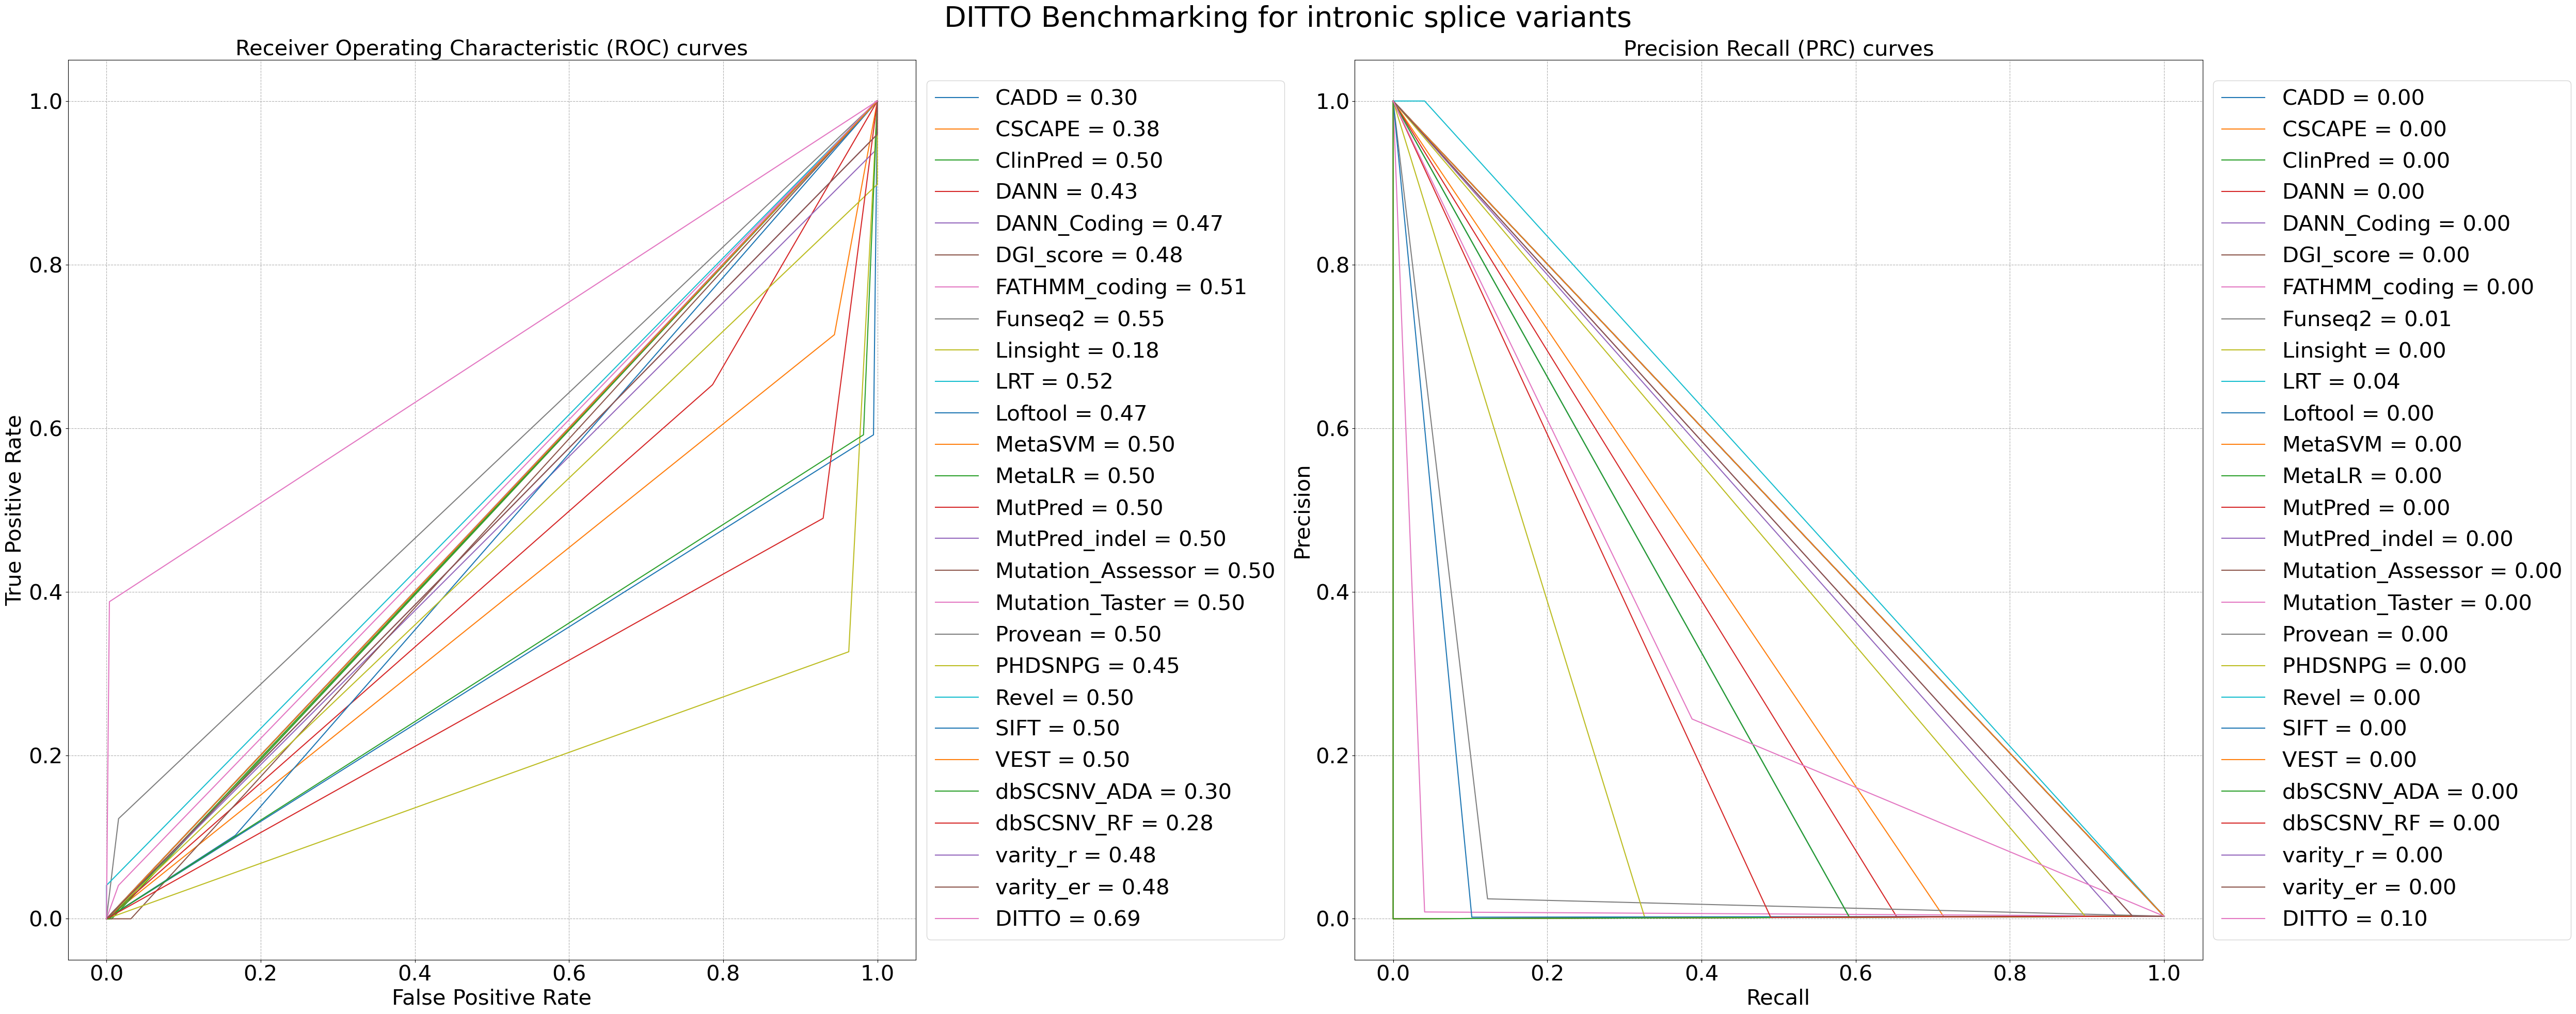

In [17]:
fig, [ax_roc, ax_prc] = plt.subplots(1, 2, figsize=(50, 20))

fig.suptitle(f"DITTO Benchmarking for intronic splice variants", fontsize=40)
fsize = 30
ax_roc.tick_params(axis='both', which='major', labelsize=fsize)
ax_prc.tick_params(axis='both', which='major', labelsize=fsize)
ax_roc.set_xlabel("False Positive Rate", fontsize=fsize)
ax_roc.set_ylabel("True Positive Rate", fontsize=fsize)
ax_roc.set_title("Receiver Operating Characteristic (ROC) curves", fontsize=fsize)
ax_roc.grid(linestyle="--")
ax_prc.set_xlabel("Recall", fontsize=fsize)
ax_prc.set_ylabel("Precision", fontsize=fsize)
ax_prc.set_title("Precision Recall (PRC) curves", fontsize=fsize)
ax_prc.grid(linestyle="--")

scores = {}
scores['roc'] = {}
scores['prc'] = {}
scores['f1'] = {}
for name in list(benchmark_df.columns):
        fpr, tpr, _ = roc_curve(Y_test, benchmark_df[name].round(), sample_weight= weights)
        auc = roc_auc_score(Y_test, benchmark_df[name].round(), sample_weight= weights, average='weighted')
        auc = "{:.2f}".format(auc)
        scores['roc'][name] = auc
        ax_roc.plot(fpr,tpr,label=str(name)+" = "+str(auc))
        precision, recall, _ = precision_recall_curve(Y_test, benchmark_df[name].round(), sample_weight= weights)
        prc = average_precision_score(Y_test, benchmark_df[name].round(), sample_weight= weights, average='weighted')
        prc = "{:.2f}".format(prc)
        scores['prc'][name] = prc
        f1 = f1_score(Y_test, benchmark_df[name].round(), sample_weight= weights, average='weighted')
        scores['f1'][name] = "{:.2f}".format(np.nanmean(f1))

        ax_prc.plot(recall,precision,label=str(name)+" = "+str(prc))
ax_prc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
ax_roc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
fig.tight_layout()
plt.savefig(
            f"/data/project/worthey_lab/projects/experimental_pipelines/tarun/DITTO/data/processed/train_data_3_star/benchmarking/intron_splice_ROC_PRC_benchmarking.pdf",
            format="pdf",
            dpi=1000,
            bbox_inches="tight",
        )


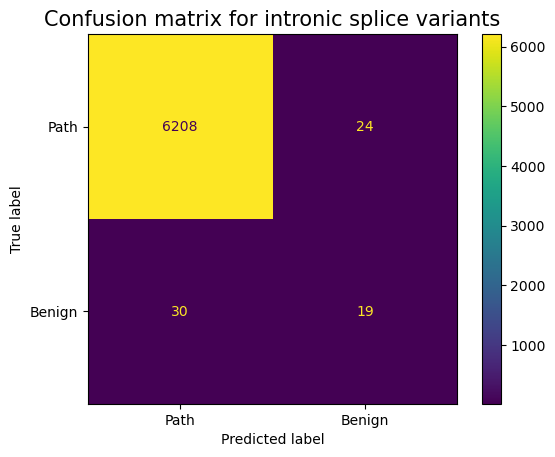

In [18]:
cm = confusion_matrix(Y_test,benchmark_df['DITTO'].round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Path', 'Benign'])
disp.plot()
plt.title(f"Confusion matrix for intronic splice variants", fontsize=15)
plt.savefig(
            f"/data/project/worthey_lab/projects/experimental_pipelines/tarun/DITTO/data/processed/train_data_3_star/benchmarking/intron_splice_matrix.pdf",
            format="pdf",
            dpi=1000,
            bbox_inches="tight",
        )


In [144]:
test_x = X_test[#(X_test['splice_site_variant']==1) &
           ((X_test['spliceai.dp_dg']<20) & (X_test['spliceai.dp_dg']!=0) &(X_test['spliceai.dp_dg']>-20) |
           (X_test['spliceai.dp_dl']<20) & (X_test['spliceai.dp_dl']!=0) &(X_test['spliceai.dp_dl']>-20) |
           (X_test['spliceai.dp_al']<20) & (X_test['spliceai.dp_al']!=0) &(X_test['spliceai.dp_al']>-20) |
           (X_test['spliceai.dp_ag']<20) & (X_test['spliceai.dp_ag']!=0) &(X_test['spliceai.dp_ag']>-20))
          ]
test_x['class'].value_counts()


1    147395
0     59812
Name: class, dtype: int64

In [145]:
y_score = clf.predict(test_x.drop("class", axis=1))
Y_test = test_x['class']
benchmark_df = test_x[config_dict['Benchmark_cols'].keys()]
benchmark_df.columns = benchmark_df.columns.to_series().map(config_dict['Benchmark_cols'])
benchmark_df_names = benchmark_df.columns.tolist()
min_max_scaler = MinMaxScaler()
benchmark_df = min_max_scaler.fit_transform(benchmark_df)
benchmark_df = pd.DataFrame(benchmark_df)
benchmark_df.columns = benchmark_df_names
benchmark_df['DITTO'] = y_score
benchmark_df.shape
weights = np.array([class_weights[i] for i in  Y_test])


6476/6476 [==============================] - 5s 722us/step


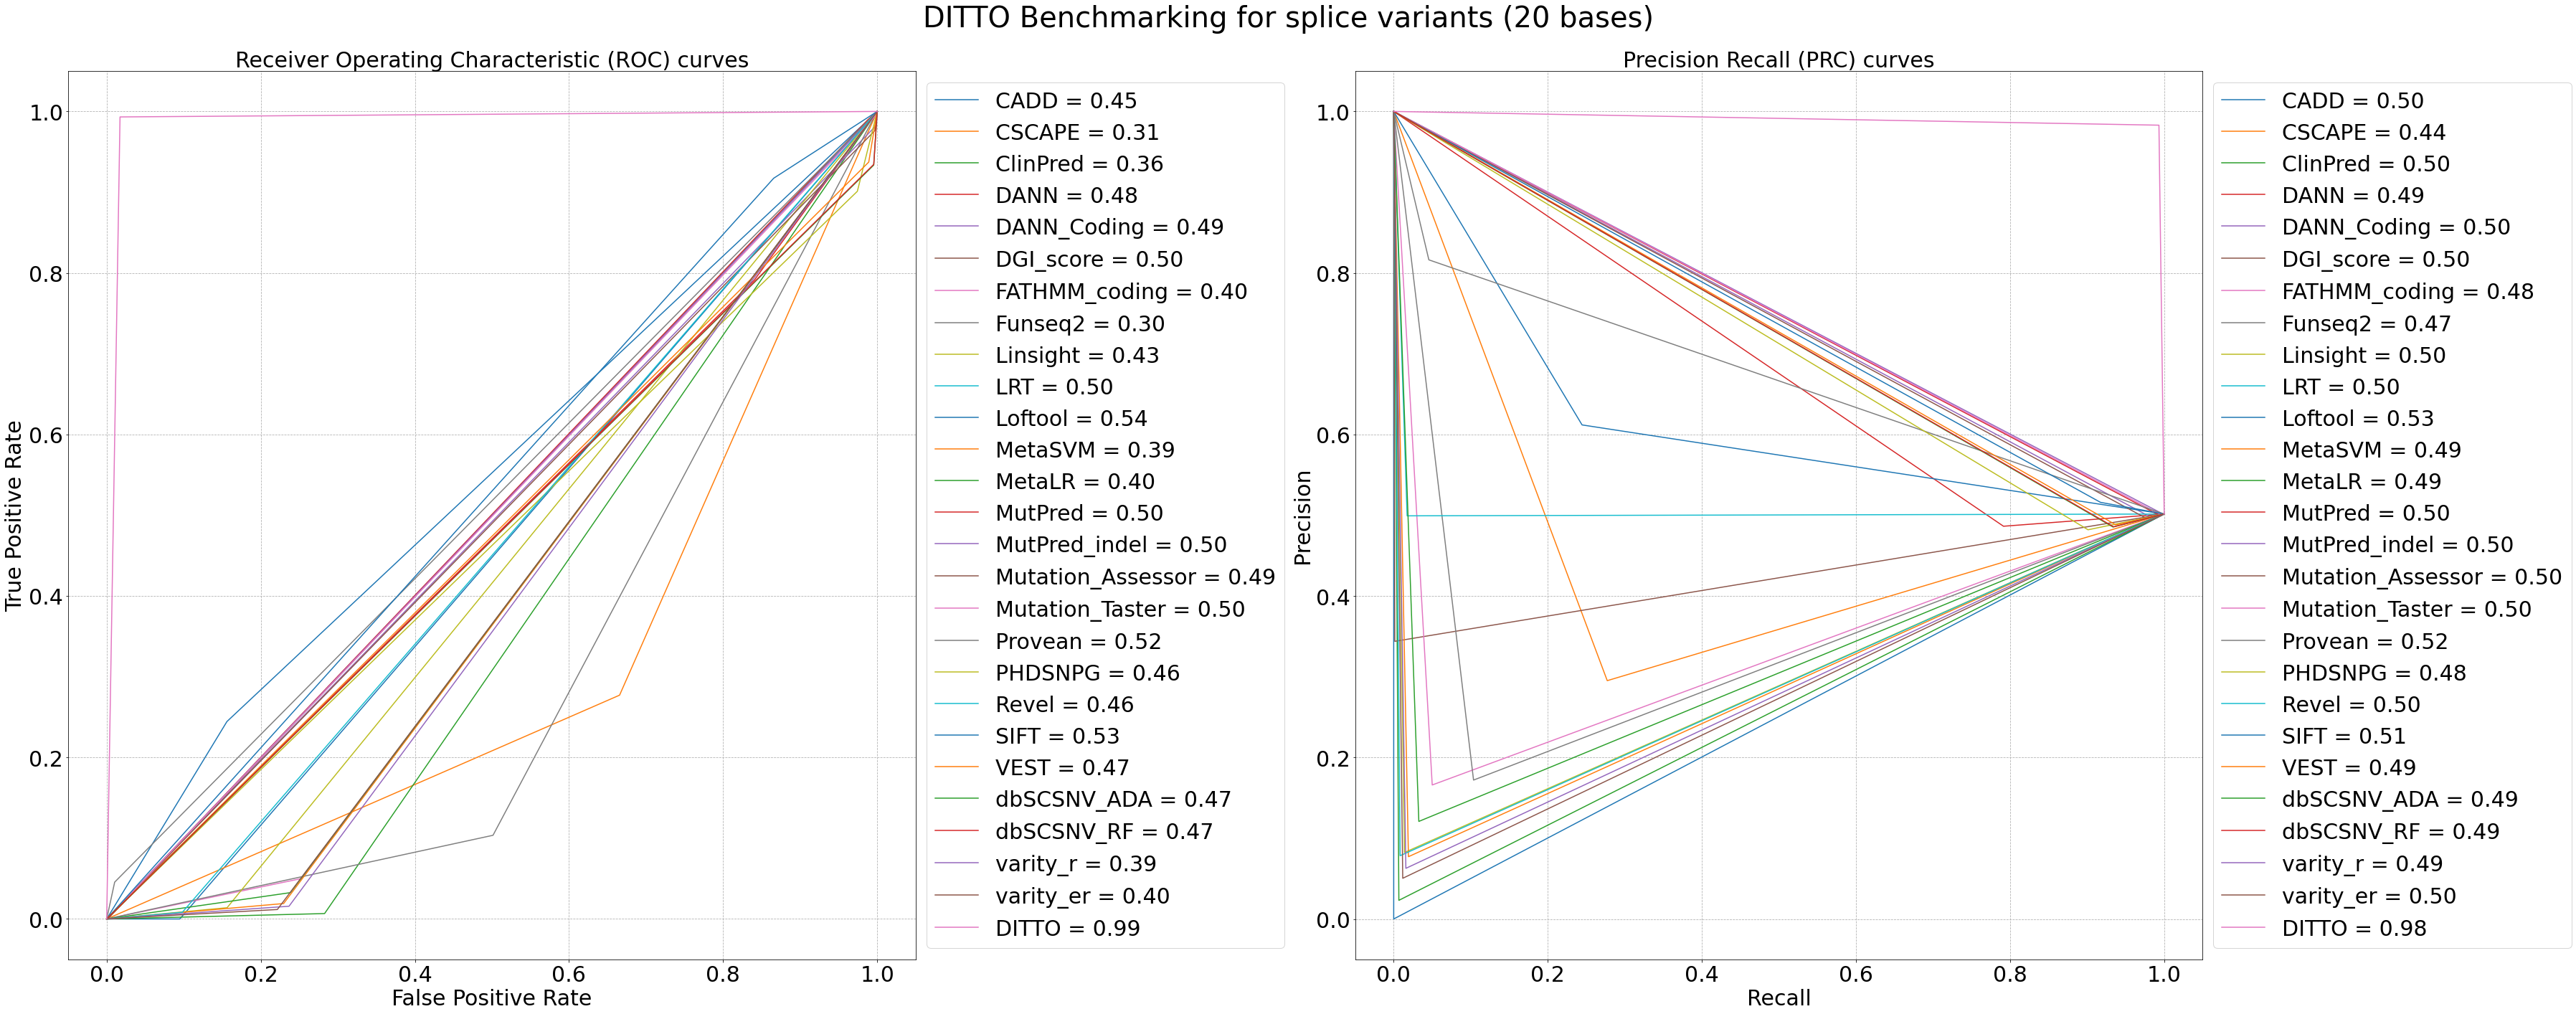

In [146]:
fig, [ax_roc, ax_prc] = plt.subplots(1, 2, figsize=(50, 20))

fig.suptitle(f"DITTO Benchmarking for splice variants (20 bases)", fontsize=40)
fsize = 30
ax_roc.tick_params(axis='both', which='major', labelsize=fsize)
ax_prc.tick_params(axis='both', which='major', labelsize=fsize)
ax_roc.set_xlabel("False Positive Rate", fontsize=fsize)
ax_roc.set_ylabel("True Positive Rate", fontsize=fsize)
ax_roc.set_title("Receiver Operating Characteristic (ROC) curves", fontsize=fsize)
ax_roc.grid(linestyle="--")
ax_prc.set_xlabel("Recall", fontsize=fsize)
ax_prc.set_ylabel("Precision", fontsize=fsize)
ax_prc.set_title("Precision Recall (PRC) curves", fontsize=fsize)
ax_prc.grid(linestyle="--")

scores = {}
scores['roc'] = {}
scores['prc'] = {}
scores['f1'] = {}
for name in list(benchmark_df.columns):
        fpr, tpr, _ = roc_curve(Y_test, benchmark_df[name].round(), sample_weight= weights)
        auc = roc_auc_score(Y_test, benchmark_df[name].round(), sample_weight= weights, average='weighted')
        auc = "{:.2f}".format(auc)
        scores['roc'][name] = auc
        ax_roc.plot(fpr,tpr,label=str(name)+" = "+str(auc))
        precision, recall, _ = precision_recall_curve(Y_test, benchmark_df[name].round(), sample_weight= weights)
        prc = average_precision_score(Y_test, benchmark_df[name].round(), sample_weight= weights, average='weighted')
        prc = "{:.2f}".format(prc)
        scores['prc'][name] = prc
        f1 = f1_score(Y_test, benchmark_df[name].round(), sample_weight= weights, average='weighted')
        scores['f1'][name] = "{:.2f}".format(np.nanmean(f1))

        ax_prc.plot(recall,precision,label=str(name)+" = "+str(prc))
ax_prc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
ax_roc.legend( bbox_to_anchor=(1,0.5), loc="center left", fontsize=fsize)
fig.tight_layout()


Text(0.5, 1.0, 'Confusion matrix for intronic splice variants')

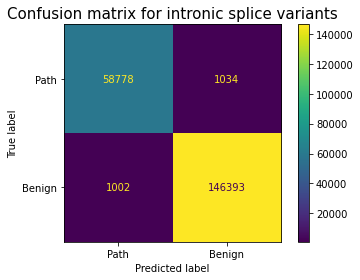

In [147]:
cm = confusion_matrix(Y_test,benchmark_df['DITTO'].round())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Path', 'Benign'])
disp.plot()
plt.title(f"Confusion matrix for intronic splice variants", fontsize=15)


In [35]:
name  = 'CADD'
precision, recall, _ = precision_recall_curve(Y_test, benchmark_df[name].values)
prc = average_precision_score(Y_test, benchmark_df[name].values)
f1 = 2 * (precision * recall) / (precision + recall)
#f1 = f1_score(Y_test, benchmark_df['DITTO'].values, average='weighted')
print(np.mean(precision), np.mean(recall), prc, np.nanmean(f1))


0.5551893504463872 0.5432009275050304 0.5163096768261702 0.5425231117777737


ValueError: Cannot take a larger sample than population when 'replace=False'

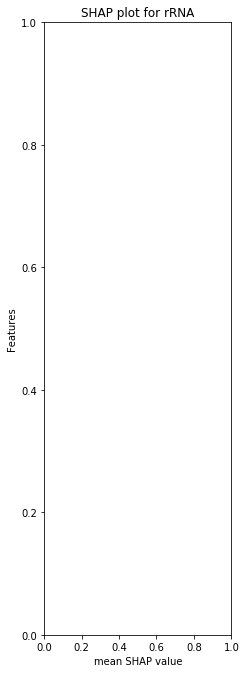

In [29]:
for so in config_dict['consequence_cols']:
    plt.clf()
    #plt.suptitle("Benchmarking damage prediction tools", fontsize=10)
    plt.xlabel("mean SHAP value")
    plt.ylabel("Features")
    plt.title(f"SHAP plot for {so}")

    test_x = X_test[X_test[so]==1].values
    background_x = test_x[np.random.choice(test_x.shape[0], 10, replace=False)]
    explainer = shap.KernelExplainer(model = clf, data = background_x) #(background_so, background_x))
    shap_values = explainer.shap_values(background_x)
    shap.summary_plot(shap_values, background_x, feature_names, show=False)
    #plt.show()
    plt.savefig(
        f"/data/project/worthey_lab/projects/experimental_pipelines/tarun/DITTO/data/processed/DITTO_NN/{so}_SHAP.pdf",
        format="pdf",
        dpi=1000,
        bbox_inches="tight",
    )


In [37]:
X_test.groupby('Clinvar').agg({'Ditto_Deleterious': ['count','mean', 'std','max','min']})


Ditto_Deleterious                                \
                                         count      mean       std       max   
Clinvar                                                                        
Benign                                  179791  0.008565  0.062959  0.994203   
Benign/Likely benign                     28860  0.015159  0.073366  0.994203   
Likely benign                           380504  0.013899  0.084063  0.994203   
Likely pathogenic                        42358  0.950448  0.154112  0.994203   
Pathogenic                               78342  0.971683  0.116882  0.994203   
Pathogenic/Likely pathogenic             10171  0.963383  0.129160  0.994203   

                                        
                                   min  
Clinvar                                 
Benign                        0.000534  
Benign/Likely benign          0.000534  
Likely benign                 0.000534  
Likely pathogenic             0.000534  
Pathogenic                    0.000534  
Pathogenic/Likely pathogenic  0.000534

In [38]:
X_test[X_test['Ditto_Deleterious'] >= 0.5].groupby('Clinvar').agg({'Ditto_Deleterious': ['count','mean', 'std','max','min']})


Ditto_Deleterious                                \
                                         count      mean       std       max   
Clinvar                                                                        
Benign                                     877  0.804318  0.160231  0.994203   
Benign/Likely benign                       178  0.787771  0.161176  0.994203   
Likely benign                             3398  0.807820  0.156124  0.994203   
Likely pathogenic                        40946  0.976289  0.060509  0.994203   
Pathogenic                               76968  0.986038  0.041426  0.994203   
Pathogenic/Likely pathogenic              9939  0.981162  0.051372  0.994203   

                                        
                                   min  
Clinvar                                 
Benign                        0.500199  
Benign/Likely benign          0.504366  
Likely benign                 0.500135  
Likely pathogenic             0.500200  
Pathogenic                    0.500938  
Pathogenic/Likely pathogenic  0.523598

In [39]:
X_test[X_test['Clinvar'].isin(["Pathogenic","Pathogenic/Likely pathogenic","Likely pathogenic"])].agg({'Ditto_Deleterious': ['count','mean', 'std','max','min']})


Ditto_Deleterious
count      130871.000000
mean            0.963682
std             0.131438
max             0.994203
min             0.000534

In [40]:
Y_test = X_test['Clinvar'].replace(r'Pathogenic/Likely pathogenic','1').replace(r'Pathogenic','1').str.replace(r'Likely pathogenic','1').replace(r'Benign/Likely benign','0').replace(r'Likely benign','0').replace(r'Benign','0').astype('int8')
X_test = X_test.drop('Clinvar', axis=1)
Y_test.value_counts()


0    589155
1    130871
Name: Clinvar, dtype: int64

In [41]:
X_test.columns


Index(['CADD', 'Cscape', 'Cscape_coding', 'Clinpred', 'DANN', 'DANN_coding',
       'DGI', 'fathmm', 'fathmm_mkl', 'funseq2', 'linsight', 'LRT', 'loftool',
       'MetaSVM', 'MetaLR', 'Mutpred', 'Mutpred_indel', 'Mutation_assessor',
       'Mutationtaster', 'Provean', 'phdsnpg', 'revel', 'SIFT', 'VEST',
       'dbscsnv.ada_score', 'dbscsnv.rf_score', 'Ditto_Deleterious'],
      dtype='object')

In [42]:
X_test.head()


CADD    Cscape  Cscape_coding  Clinpred      DANN  DANN_coding  DGI  \
1  11.850  0.284129       0.284129       NaN       NaN          NaN  NaN   
2  27.900  0.770777       0.770777     0.389  0.405896     0.999184  NaN   
4   9.328  0.247101       0.247101       NaN  0.432419          NaN  NaN   
6   1.887  0.164954       0.164954       NaN       NaN          NaN  NaN   
8     NaN  0.959408            NaN       NaN  0.531631          NaN  NaN   

   fathmm  fathmm_mkl   funseq2  ...  Mutation_assessor  Mutationtaster  \
1     NaN         NaN  0.000000  ...                NaN             NaN   
2     NaN     0.90545  2.000000  ...            0.62235         0.51968   
4     NaN         NaN  0.000000  ...                NaN             NaN   
6     NaN         NaN  0.000000  ...                NaN             NaN   
8     NaN         NaN  0.334935  ...                NaN             NaN   

   Provean  phdsnpg    revel      SIFT   VEST  dbscsnv.ada_score  \
1      NaN      NaN      NaN  0.000999    NaN                NaN   
2  0.92346     0.87  0.73877  1.000000  0.756                NaN   
4      NaN      NaN      NaN  0.000999    NaN                NaN   
6      NaN      NaN      NaN  0.000999    NaN                NaN   
8      NaN      NaN      NaN       NaN    NaN                NaN   

   dbscsnv.rf_score  Ditto_Deleterious  
1               NaN           0.000534  
2               NaN           0.117187  
4               NaN           0.000534  
6               NaN           0.000534  
8               NaN           0.000598  

[5 rows x 27 columns]